# TODO ITEMS

1. Possibly change loss weighting on adversarial vs. content in generator loss function

DONE:

1. Normalize input to be in [0, 1], which Ledig's paper does and looks like GAN HW also put input into [-1, 1]
2. Normalize high res images to also be in [-1, 1], which is what Ledig's paper also does


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, sampler, TensorDataset
from torch.utils.data import sampler

import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np
import pickle
import os
from PIL import Image

from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import h5py

from time import time

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# From Assignment 2 PyTorch Notebook
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [3]:
# Adapted from https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py# Adapt 

HEIGHT_INDEX = 200 # Row index at which the crop begins
WIDTH_INDEX = 200  # Column index at which the crop begins

IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CHANNELS_IN = 3
NUM_CHANNELS_OUT = 2

TRAIN_FILES = 1
VAL_FILES = 0
TEST_FILES = 0
YEARS_PER_FILE = 10
IMGS_PER_YEAR = 365

class SR_Dataset(data.Dataset):
    """
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    base_folder = 'sr_data'
    elevation_file = 'dem.pkl'
    
    train_list = np.array([
        '1950s.hdf5',
#         '1960s.hdf5',
#         '1970s.hdf5'
    ])
    
    val_list = np.array([
        
    ])

    test_list = np.array([
        
    ])

    def __init__(self, root, train=True):
        
        self.root = os.path.expanduser(root)
        self.train = train  # training set or test set
        
        # load elevation data
        fo_in = open(os.path.join(self.root, self.elevation_file), 'rb')
        self.elevation = pickle.load(fo_in)
        fo_in.close()
        elev_mean = np.mean(self.elevation)
        elev_var = np.var(self.elevation)
        self.elevation = (self.elevation - elev_mean) / np.sqrt(elev_var)
        h,w = self.elevation.shape
        self.elevation = self.elevation.reshape((1,h,w))

    in_mean = np.array([1.9028055e-05, 284.676482])
    in_var = np.array([1.5503707e-09, 108.102618])
    out_mean = np.array([1.902273e-05, 284.676482])
    out_var = np.array([2.3926674e-09, 108.102618])
    
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (low_res, high_res)
        """
        t1 = time()
        file_idx = index // (YEARS_PER_FILE * IMGS_PER_YEAR)
        img_in_file = index % (YEARS_PER_FILE * IMGS_PER_YEAR)
        year_idx = img_in_file // IMGS_PER_YEAR
        idx_in_year = img_in_file % IMGS_PER_YEAR
        
        f = None
        if self.train:
            f = h5py.File(os.path.join(self.base_folder, self.train_list[file_idx]), 'r')
        else:
            f = h5py.File(os.path.join(self.base_folder, self.val_list[file_idx]), 'r')
        
        yr = list(f.keys())[year_idx]
        pr =  f[yr]['pr'][idx_in_year]
        tas = f[yr]['tas'][idx_in_year]
        f.close()
        high_res = np.flip(np.concatenate((pr[np.newaxis,:,:], tas[np.newaxis,:,:])),axis=1)
        
        # Now crop the high_res as soon as we get it
        high_res = high_res[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]

        # Also crop the elevation data to the same place
        elev_crop = self.elevation[:, HEIGHT_INDEX:(HEIGHT_INDEX+IMG_HEIGHT), WIDTH_INDEX:(WIDTH_INDEX+IMG_WIDTH)]

        # get the input LR image from output HR image by blurring, cropping, then interpolating
        c,h1,w1 = high_res.shape
        blurred = np.zeros_like(high_res)
        blurred = gaussian_filter(high_res, sigma = (0, 0.55, 0.55))
        half_res = blurred[:, ::2, ::2]
        # Code involved in interpolating the blurred image back up to high res resolution
        c,h2,w2 = half_res.shape
        x = np.arange(h2)
        y = np.arange(w2)
        xnew = np.arange(0, h2, h2/h1)
        ynew = np.arange(0, w2, w2/w1)
        low_res = np.zeros_like(high_res)
        for i in range(c):
            f = RectBivariateSpline(x, y, half_res[i, :, :])
            low_res[i, :, :] = f(xnew, ynew)
            
        # Normalize to mean 0, std 1 using precomputed statistics from the dataset
        low_res =  (low_res -  self.in_mean[:,np.newaxis,np.newaxis])  / np.sqrt(self.in_var[:,np.newaxis,np.newaxis])
        high_res = (high_res - self.out_mean[:,np.newaxis,np.newaxis]) / np.sqrt(self.out_var[:,np.newaxis,np.newaxis])
        
        # Add the elevation data to the input image
        low_res = np.concatenate((low_res, elev_crop))
        
        # Set the range of values of the training data from 0 to 1, and high res from -1 to 1, as they do in Ledig
        low_res -= np.amin(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        low_res /= np.amax(low_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        
        high_min = np.amin(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        high_max = np.amax(high_res, axis=(1,2))[:, np.newaxis, np.newaxis]
        high_res = (high_res - high_min) / ((high_max - high_min) / 2) - 1
        
        # Gotta cast the lowres to float (from double) else it confuses the model, since model's standard
        # is to assume float
        low_res = torch.from_numpy(low_res).float() 
        high_res = torch.from_numpy(high_res).float()      
        
        #print(time()-t1)
        return low_res, high_res

    def __len__(self):
        if self.train:
            return len(self.train_in)
        else:
            return len(self.test_in)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [5]:
data_directory = '.'

##########################################################################################
#                                  BATCH_SIZE PARAMETER
BATCH_SIZE = 16
##########################################################################################

sr_train = SR_Dataset(data_directory, train=True)
loader_train = DataLoader(sr_train, batch_size=BATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(TRAIN_FILES*YEARS_PER_FILE*IMGS_PER_YEAR)),
                         num_workers = 4)

#sr_val = SR_Dataset(data_directory, train=True, transform=transform, target_transform=transform)
#loader_val = DataLoader(sr_val, batch_size=batch_size, 
#                        sampler=sampler.SubsetRandomSampler(range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE)))

#sr_test = SR_Dataset(data_directory, train=True, transform=transform)
#loader_test = DataLoader(sr_test, batch_size=batch_size)

In [6]:
# Check to make sure the range on the input and output images is correct, and they're the correct shape
testx, testy = sr_train.__getitem__(3)
print("x shape: ", testx.shape)
print("y shape: ", testy.shape)
print("x min: ", torch.min(testx))
print("x max: ", torch.max(testx))
print("y min: ", torch.min(testy))
print("y max: ",torch.max(testy))


x shape:  torch.Size([3, 64, 64])
y shape:  torch.Size([2, 64, 64])
x min:  tensor(0.)
x max:  tensor(1.)
y min:  tensor(-1.)
y max:  tensor(1.)


# Loss functions

In [7]:
def bce_loss(input, target):
    """
    Taken from the homework GAN notebook. This is a helper function to be used in the loss functions of D and G
    
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs().to(device=device)
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [8]:
def discriminator_loss(logits_real, logits_fake):
    """
    
    Taken from homework 3, GAN notebook
    
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data (real numbers). 
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data (real numbers).
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    # How often it mistakes real images for fake
    N = logits_real.shape[0]
    real_labels = torch.ones(N).to(device=device, dtype=dtype)
#     L1 = bce_loss(logits_real, real_labels)
    BCE_Loss = nn.BCELoss()
    L1 = BCE_Loss(logits_real, real_labels)
    
    # How often it gets fooled into thinking fake images are real
    fake_labels = torch.zeros(N).to(device=device, dtype=dtype)
#     L2 = bce_loss(logits_fake, fake_labels)
    L2 = BCE_Loss(logits_fake, fake_labels)
    
#     print("L1 (how bad on real data): %f\t L2 (how bad on fake data): %f" % (L1, L2))
    
    loss = (L1 + L2)
    return loss, L1, L2

In [9]:
def generator_loss(gen_img, true_img, logits_fake, weight_param=1e-3):
    """
    Computes the generator loss described above.

    Inputs:
    - gen_img: (PyTorch tensor) shape N, C image generated by the Generator, so that we can calculate MSE
    - true_img: (PyTorch tensor) the true, high res image, so that we can calculate the MSE
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    - weight_param: how much to weight the adversarial loss by when summing the losses. Default in Ledig paper is 1e-3
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    # Content loss - MSE loss for now. Ludig paper also suggests using
    # Euclidean distance between feature vector of true image and generated image, 
    # where we get the feature vector from a pretrained VGGnet. Probably wouldn't
    # work for us (at least pretrained) because climate data looks so different from normal pictures
    content_loss_func = nn.MSELoss()
    content_loss = content_loss_func(gen_img, true_img)
        
    
    N = logits_fake.shape[0]
    desired_labels = torch.ones(N).to(device=device, dtype=dtype)
#     adversarial_loss = bce_loss(logits_fake, desired_labels)
    BCE_Loss = nn.BCELoss()
    adversarial_loss = BCE_Loss(logits_fake, desired_labels)
    return content_loss + weight_param*adversarial_loss, content_loss, adversarial_loss
    
    

In [10]:
def get_optimizer(model, lr=1e-3):
    """
    Copied from homework GAN notebook since I'll copy their training function too anyways
    
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.9))
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr, )
    return optimizer

# Network Architectures

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [12]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, H=IMG_HEIGHT, W=IMG_WIDTH):
        super().__init__()
        
        self.layers = nn.Sequential( 
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            Flatten(),
            nn.Linear(512*np.ceil(H/16)*np.ceil(W/16), 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        return self.layers(x)

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64)
        )

    def forward(self, x):
        return x + self.layers(x)

class UpscaleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 256, 3, stride=1, padding=0),
            nn.PixelShuffle(upscale_factor=2),
            nn.PReLU()
        )
    
    def forward(self, x):
        return self.layers(x)
        

#######################################################################################################
#   DO I NEED TO TURN BATCHNORM OFF AT TEST TIME TO COPY PAPER OR DOES PYTORCH DO THAT AUTOMATICALLY??
#######################################################################################################

class Generator(nn.Module):
    def __init__(self, num_channels, num_res_blocks=16, scale_factor=2):
#         upsample_block_num = int(math.log(scale_factor, 2))

        super().__init__()
        # Store the number of residual blocks, we need this number in the forward() function
        self.num_res_blocks = num_res_blocks
        
        self.initial_conv = nn.Sequential(
            nn.ReplicationPad2d(4),
            nn.Conv2d(num_channels, 64, kernel_size=9, stride=1, padding=0),
            nn.PReLU()
        )
        
        # List of residual blocks
        self.resBlocks = nn.ModuleList([ResidualBlock(64) for i in range(self.num_res_blocks)])

        self.post_resid_conv = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.BatchNorm2d(64)
        )
    
        # We chose to remove the pixelshuffle blocks and instead interpolate ahead of time
#         self.num_upscale_blocks = scale_factor // 2
#         self.upscaleBlocks = nn.ModuleList([UpscaleBlock() for i in range(self.num_upscale_blocks)])
        
        # Instead, just do one conv-prelu block, without the pixelshuffle in between
        self.conv_prelu = nn.Sequential(
            nn.ReplicationPad2d(1),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.PReLU()
        )
    
        self.final_conv = nn.Sequential(
            nn.ReplicationPad2d(4),
            nn.Conv2d(64, 2, 9, stride=1, padding=0)
        )


    def forward(self, x):
        initial_conv_out = self.initial_conv(x)
                
        res_block_out = self.resBlocks[0](initial_conv_out)
        for i in range(1, self.num_res_blocks):
            res_block_out = self.resBlocks[i](res_block_out)

        post_resid_conv_out = self.post_resid_conv(res_block_out) + initial_conv_out
        conv_prelu_out = self.conv_prelu(post_resid_conv_out)
        final_out = self.final_conv(conv_prelu_out)


        return F.tanh(final_out) 
#         return (F.tanh(block8) + 1) / 2  # From reference code, not sure why he does this to put it in [0 1]

# Test Generator and Discriminator to make sure they run

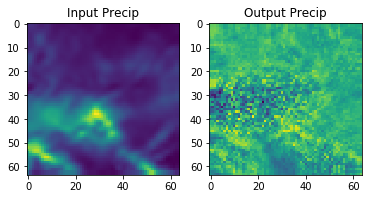

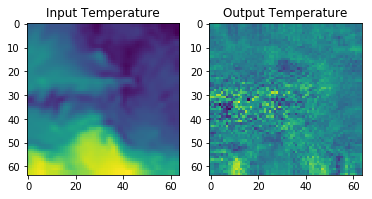

In [14]:
def test_Generator():
    h = 32
    w = h
#     x = torch.zeros((1, NUM_CHANNELS_IN, h, w), dtype=dtype)  # minibatch size 64, feature dimension 50
    x = (sr_train.__getitem__(3)[0]).unsqueeze_(0)
    model = Generator(NUM_CHANNELS_IN, scale_factor=2)
    model = model.to(device=device)
#     model = model.cuda()
    x = x.to(device=device, dtype=dtype)
    output = model(x)
#     print(np.amin(output[0,1,:,:].detach().numpy()))
    plt.subplot(121)
    plt.imshow(x.cpu().detach().numpy()[0, 0, :, :])
    plt.title("Input Precip")
    plt.subplot(122)
    plt.imshow(output.cpu().detach().numpy()[0, 0, :, :])
    plt.title("Output Precip")
    plt.figure()
    plt.subplot(121)
    plt.imshow(x.cpu().detach().numpy()[0, 1, :, :])
    plt.title("Input Temperature")
    plt.subplot(122)
    plt.imshow(output.cpu().detach().numpy()[0, 1, :, :])
    plt.title("Output Temperature")
    plt.show()
test_Generator()

In [15]:
def test_Discriminator():
    x = (sr_train.__getitem__(3)[0]).unsqueeze_(0)
    print("x: ", x.shape)
    model = Discriminator(NUM_CHANNELS_IN)
    output = model(x)
    print(output.size())
    print(output)
test_Discriminator()

x:  torch.Size([1, 3, 64, 64])
torch.Size([1, 1])
tensor([[ 0.5240]])


In [16]:
def plot_epoch(x, y_pred, y):
    figsize = (9,4)
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plt.imshow(x[0,0,:,:].cpu().detach().numpy())
    plt.title("Input Precip")
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0,0,:,:].cpu().detach().numpy())
    plt.title("Output Precip")
    plt.subplot(1,3,3)
    plt.imshow(y[0,0,:,:].cpu().detach().numpy())
    plt.title("True Precip")
    
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plt.imshow(x[0,1,:,:].cpu().detach().numpy())
    plt.title("Input Temp")
    plt.subplot(1,3,2)
    plt.imshow(y_pred[0,1,:,:].cpu().detach().numpy())
    plt.title("Output Temp")
    plt.subplot(1,3,3)
    plt.imshow(y[0,1,:,:].cpu().detach().numpy())
    plt.title("True Temp")
    plt.show()
    
def plot_loss(G_content, G_advers, D_real_L, D_fake_L, iter_count):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(range(iter_count), G_content[range(iter_count)])
    plt.plot(range(iter_count), G_advers[range(iter_count)])
    plt.plot(range(iter_count), G_content[range(iter_count)] + G_advers[range(iter_count)])
    plt.legend(("Content", "Adversarial", "Total"))
    plt.title("Generator loss")
    plt.xlabel("Iteration")
    
    plt.subplot(1,2,2)
    plt.plot(range(iter_count), D_real_L[range(iter_count)])
    plt.plot(range(iter_count), D_fake_L[range(iter_count)])
    plt.plot(range(iter_count), D_real_L[range(iter_count)] + D_fake_L[range(iter_count)])
    plt.legend(("Real Pic", "Fake Pic", "Total"))
    plt.title("Discriminator loss")
    plt.xlabel("Iteration")
    plt.show()

In [27]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, num_epochs=5):
    """
    FROM THE HOMEWORK
    
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    # Move the models to the correct device (GPU if GPU is available)
    D = D.to(device=device)
    G = G.to(device=device)
    
    # Put models in training mode
    D.train()
    G.train()
    
#     D_loss_history = np.zeros(len(loader_train)*)
    print("Expected num iters: ", len(loader_train)*BATCH_SIZE*num_epochs)
    G_content = np.zeros(len(loader_train)*BATCH_SIZE*num_epochs)
    G_advers = np.zeros(len(loader_train)*BATCH_SIZE*num_epochs)
    D_real_L = np.zeros(len(loader_train)*BATCH_SIZE*num_epochs)
    D_fake_L = np.zeros(len(loader_train)*BATCH_SIZE*num_epochs)
    
    
    
    iter_count = 0
    for epoch in range(num_epochs):
        for x,y in loader_train:
                
            # Update for the discriminator
            D_solver.zero_grad()
            high_res_imgs = y.to(device=device, dtype=dtype)
            logits_real = D(high_res_imgs)

            low_res_imgs = x.to(device=device, dtype=dtype)
            fake_images = G(low_res_imgs).detach()
            logits_fake = D(fake_images)
    
            d_total_error, D_real_L[iter_count], D_fake_L[iter_count] = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()
            D_solver.step()


            # Update for the generator
            G_solver.zero_grad()
            gen_logits_fake = D(fake_images)
            g_error, G_content[iter_count], G_advers[iter_count] = generator_loss(fake_images, high_res_imgs, gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
#                 print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                plot_epoch(x, fake_images, y)
                plot_loss(G_content, G_advers, D_real_L, D_fake_L, iter_count)
                print()
            iter_count += 1

Expected num iters:  18320


/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


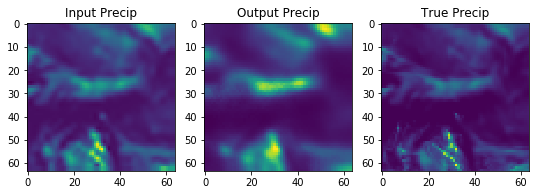

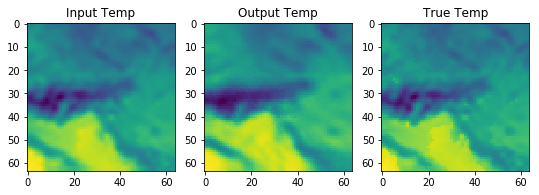

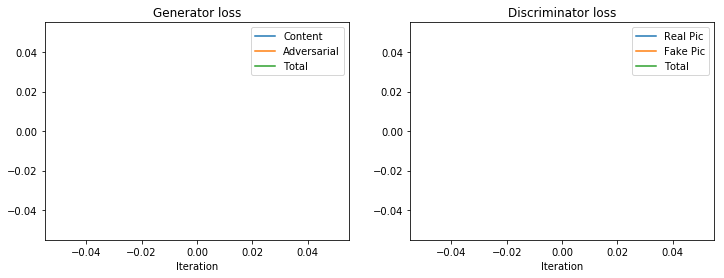

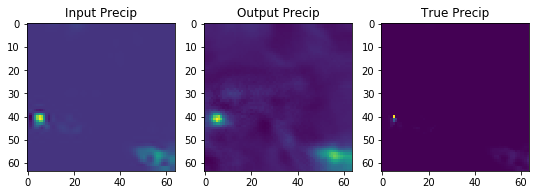

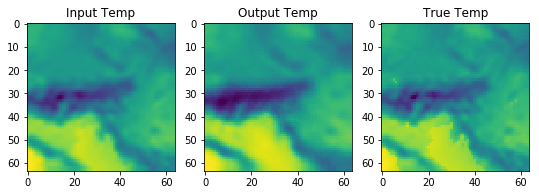

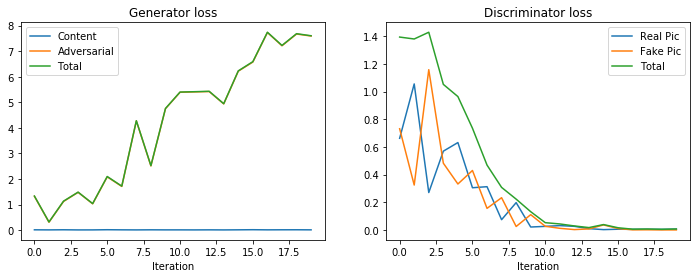

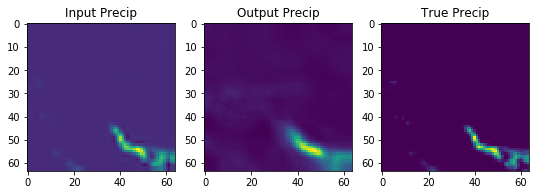

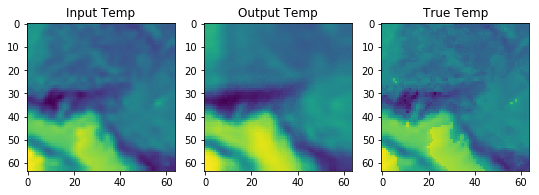

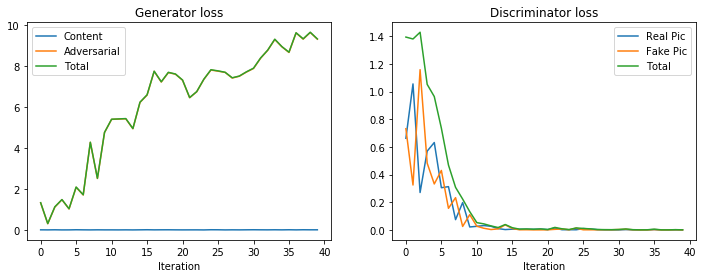

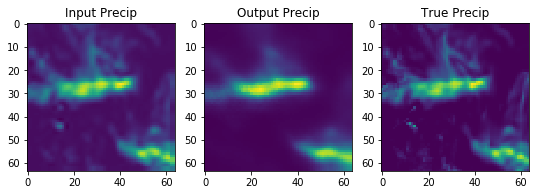

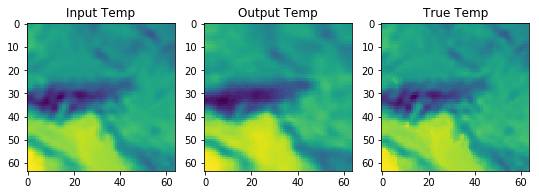

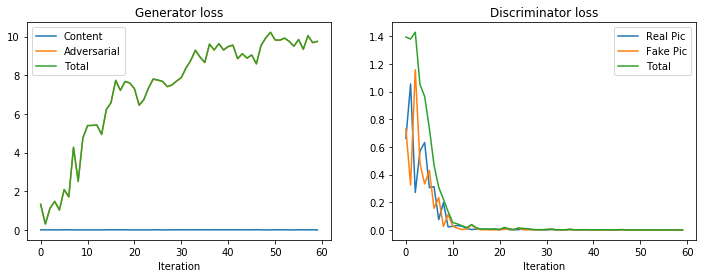

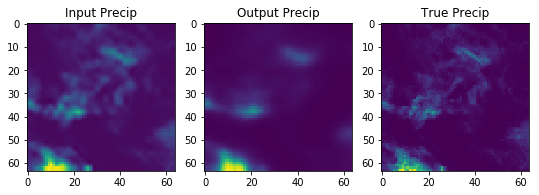

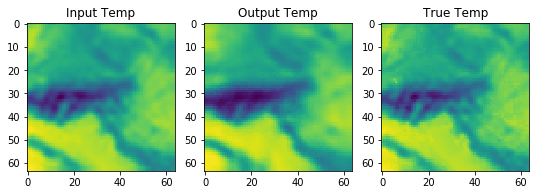

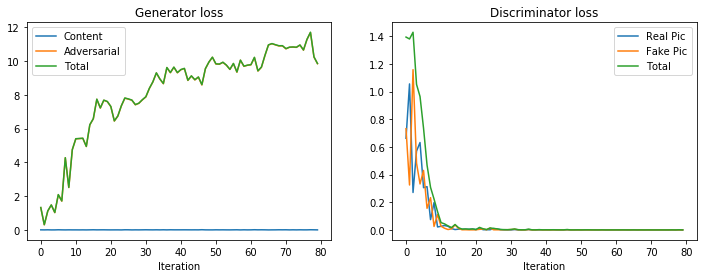

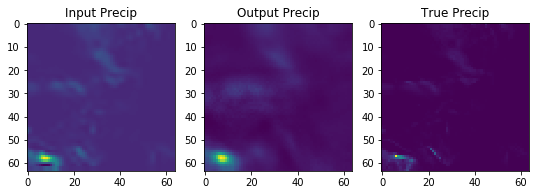

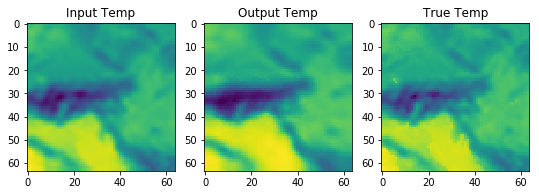

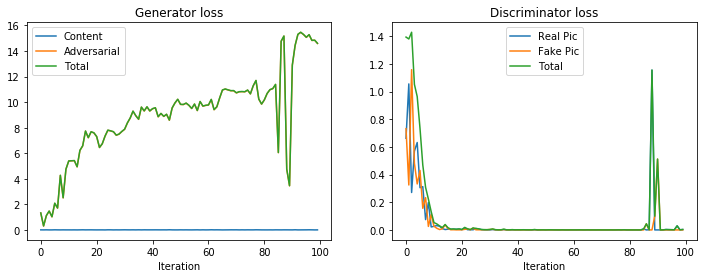

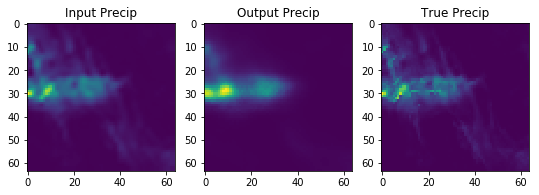

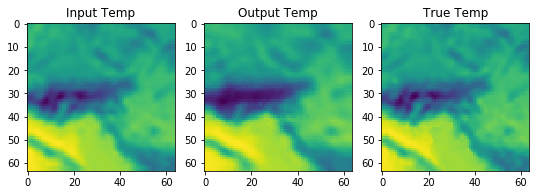

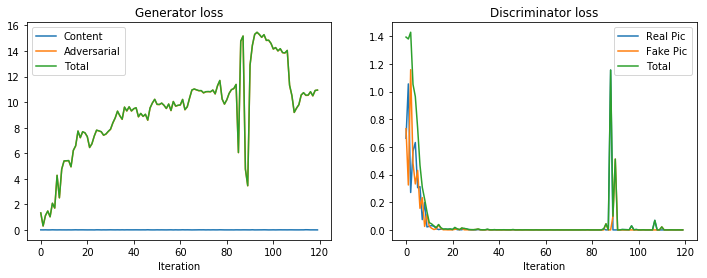

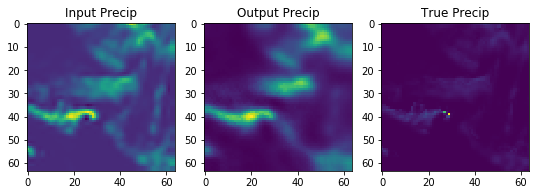

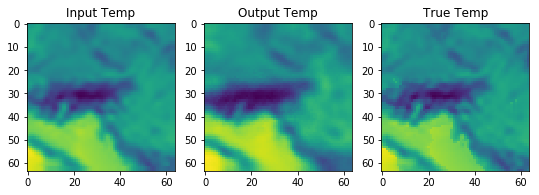

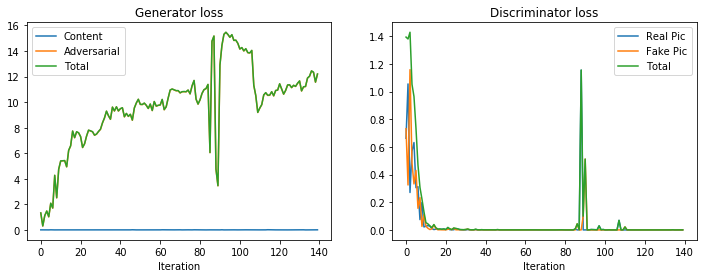

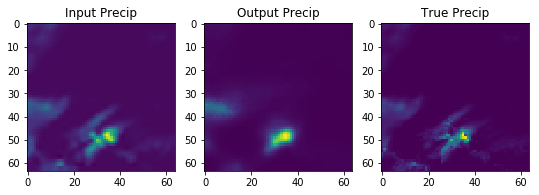

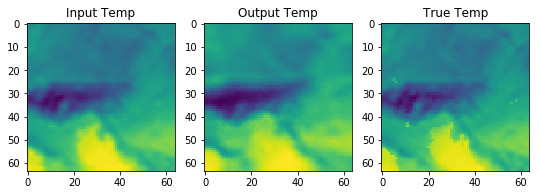

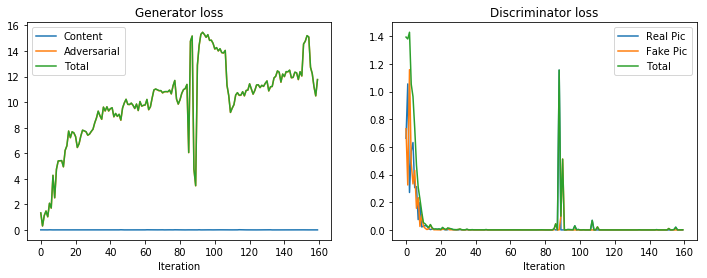

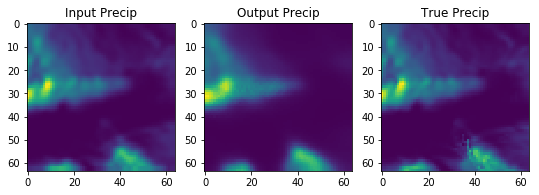

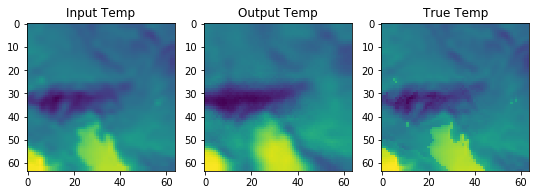

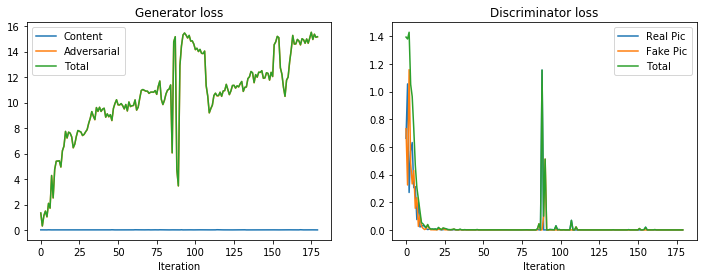

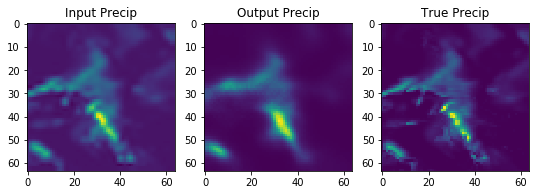

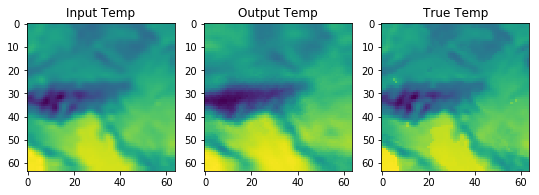

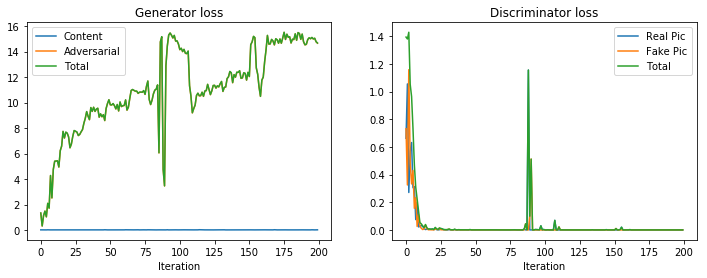

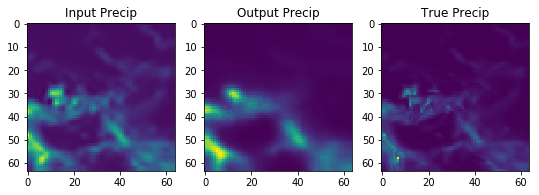

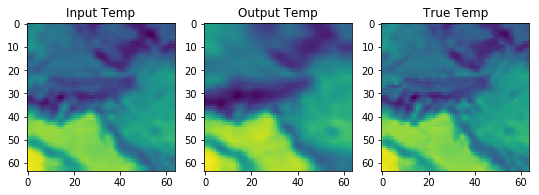

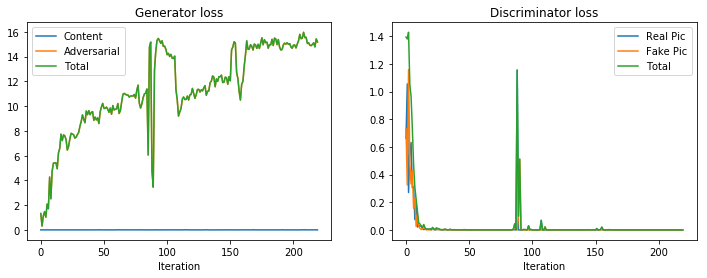

/home/shared/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


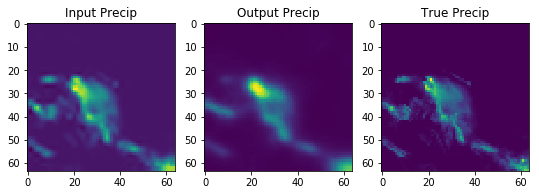

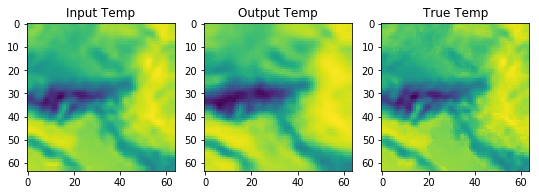

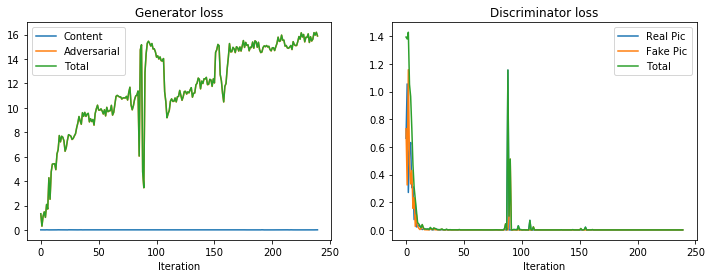

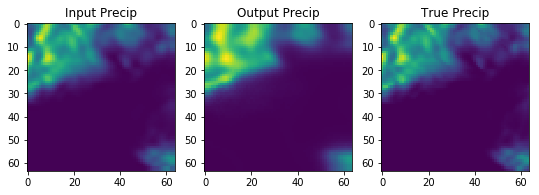

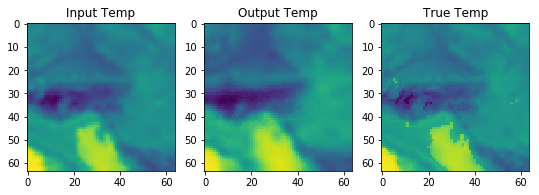

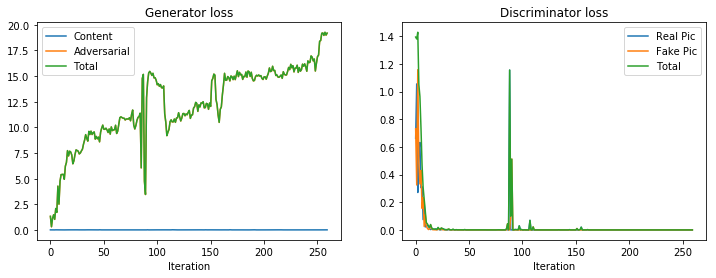

Process Process-27:
Process Process-28:
Process Process-26:
Process Process-25:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiproces

KeyboardInterrupt: 

In [28]:
D = Discriminator(num_channels=2, H=IMG_HEIGHT, W=IMG_WIDTH)
G = Generator(num_channels=3)

# Initialize the Generator to the checkpoint created when training it alone
G.load_state_dict(torch.load('training_Generator_checkpoint.pt'))

D_solver = get_optimizer(D, lr=1e-4)
G_solver = get_optimizer(G)

run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=20)

In [22]:
# Function to just train generator first, since it doesn't seem to do well in the GAN setup 
# when it starts from a random initialization
def train_generator(optimizer, model, print_every=10, epochs=5):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            y_predicted = model(x)
            loss_func = nn.MSELoss()
            loss = loss_func(y_predicted, y)
            
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                
                plt.subplot(1,3,1)
                plt.imshow(x[0][0].cpu().detach().numpy())
                plt.title("Input Precip")
                plt.subplot(1,3,2)
                plt.imshow(y_predicted[0][0].cpu().detach().numpy())
                plt.title("Output Precip")
                plt.subplot(1,3,3)
                plt.imshow(y[0][0].cpu().detach().numpy())
                plt.title("True Precip")
                plt.show()
                
                plt.subplot(1,3,1)
                plt.imshow(x[0][1].cpu().detach().numpy())
                plt.title("Input Temp")
                plt.subplot(1,3,2)
                plt.imshow(y_predicted[0][1].cpu().detach().numpy())
                plt.title("Output Temp")
                plt.subplot(1,3,3)
                plt.imshow(y[0][1].cpu().detach().numpy())
                plt.title("True Temp")
                plt.show()
                
                #check_accuracy(loader_val, model)
                
            del x, y, loss
            
    # At the end of training, save the model's state
    torch.save(model.cpu().state_dict(), 'training_Generator_checkpoint.pt')

Iteration 0, loss = 0.4791


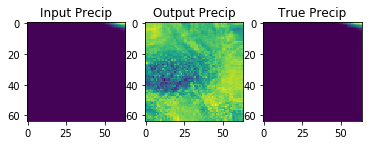

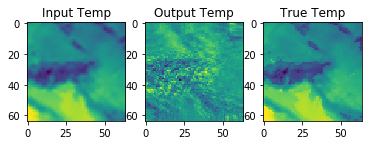

Iteration 10, loss = 0.0237


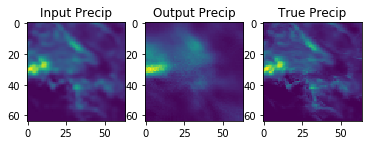

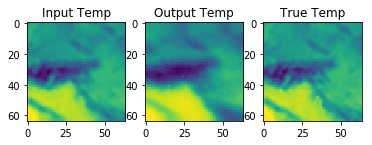

Iteration 20, loss = 0.0149


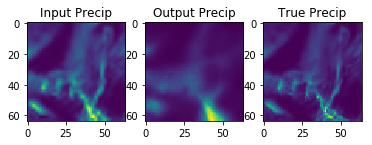

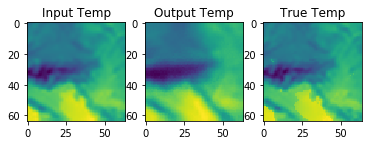

Iteration 30, loss = 0.0127


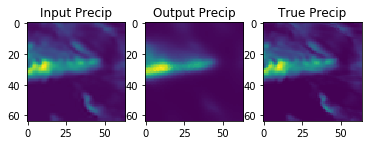

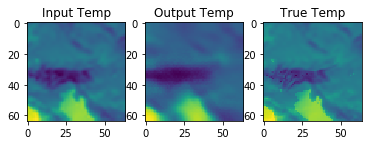

Iteration 40, loss = 0.0104


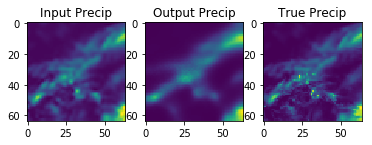

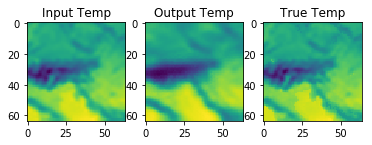

Iteration 50, loss = 0.0103


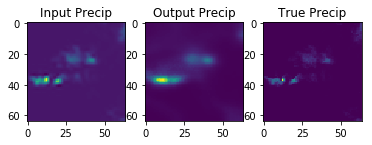

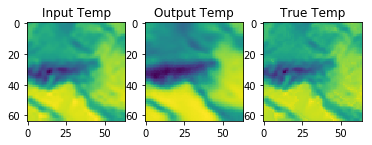

Iteration 60, loss = 0.0091


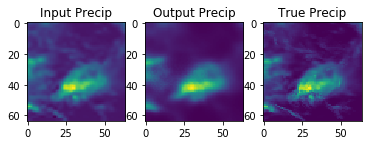

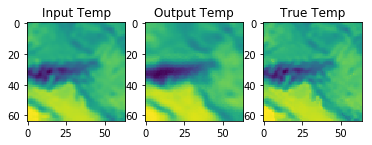

Iteration 70, loss = 0.0083


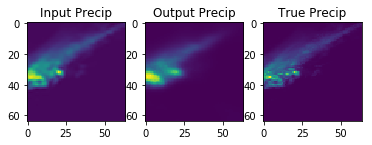

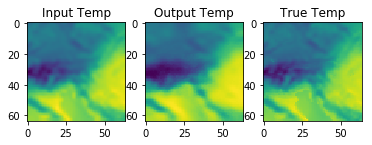

In [24]:
learning_rate = 1e-4

model = Generator(3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_generator(optimizer, model, epochs=1)

In [40]:
torch.save(model.cpu().state_dict(), 'training_Generator_checkpoint.pt')

Expected num iters:  18280
L1 (how bad on real data): 0.478705	 L2 (how bad on fake data): 0.968896


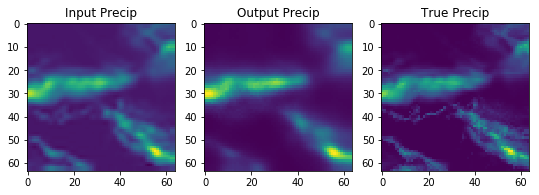

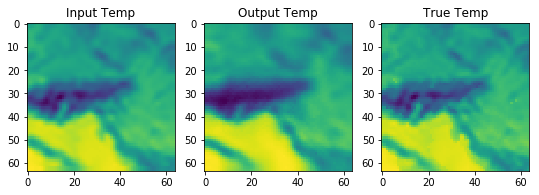

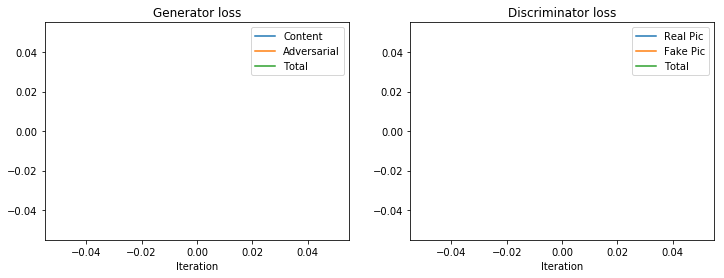


L1 (how bad on real data): 0.573380	 L2 (how bad on fake data): 0.791952
L1 (how bad on real data): 0.633949	 L2 (how bad on fake data): 0.727520
L1 (how bad on real data): 0.594769	 L2 (how bad on fake data): 0.740379
L1 (how bad on real data): 0.474291	 L2 (how bad on fake data): 0.811410
L1 (how bad on real data): 0.421882	 L2 (how bad on fake data): 0.786982
L1 (how bad on real data): 0.425958	 L2 (how bad on fake data): 0.719534
L1 (how bad on real data): 0.321792	 L2 (how bad on fake data): 0.861668
L1 (how bad on real data): 0.508238	 L2 (how bad on fake data): 0.704931
L1 (how bad on real data): 0.341016	 L2 (how bad on fake data): 0.696250
L1 (how bad on real data): 0.320579	 L2 (how bad on fake data): 0.782077
L1 (how bad on real data): 0.322298	 L2 (how bad on fake data): 0.695074
L1 (how bad on real data): 0.318075	 L2 (how bad on fake data): 0.696061
L1 (how bad on real data): 0.317725	 L2 (how bad on fake data): 0.695485
L1 (how bad on real data): 0.333524	 L2 (how bad o

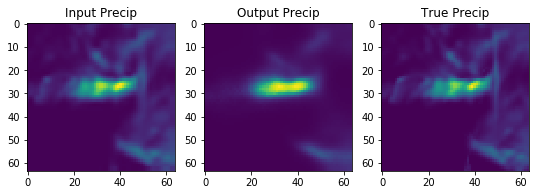

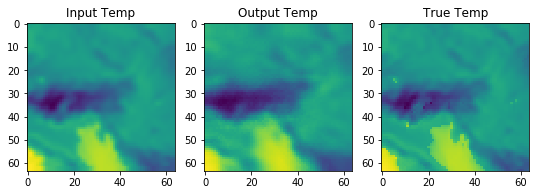

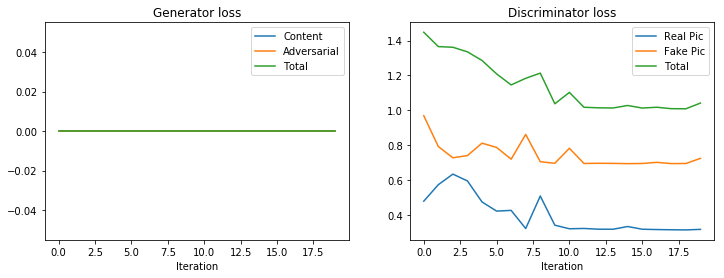


L1 (how bad on real data): 0.319187	 L2 (how bad on fake data): 0.699779
L1 (how bad on real data): 0.333272	 L2 (how bad on fake data): 0.693742
L1 (how bad on real data): 0.314030	 L2 (how bad on fake data): 0.694478
L1 (how bad on real data): 0.313640	 L2 (how bad on fake data): 0.693971
L1 (how bad on real data): 0.313538	 L2 (how bad on fake data): 0.697489
L1 (how bad on real data): 0.313475	 L2 (how bad on fake data): 0.693365
L1 (how bad on real data): 0.313644	 L2 (how bad on fake data): 0.694562
L1 (how bad on real data): 0.313561	 L2 (how bad on fake data): 0.693675
L1 (how bad on real data): 0.315440	 L2 (how bad on fake data): 0.693257
L1 (how bad on real data): 0.313713	 L2 (how bad on fake data): 0.693535
L1 (how bad on real data): 0.313393	 L2 (how bad on fake data): 0.693240
L1 (how bad on real data): 0.313754	 L2 (how bad on fake data): 0.693455
L1 (how bad on real data): 0.314383	 L2 (how bad on fake data): 0.693484
L1 (how bad on real data): 0.313584	 L2 (how bad o

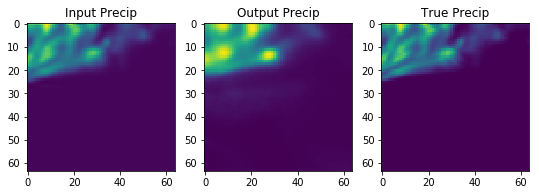

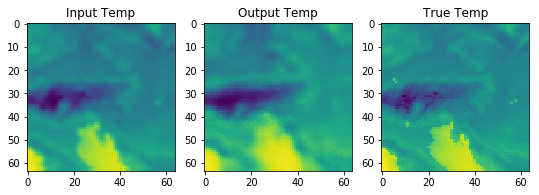

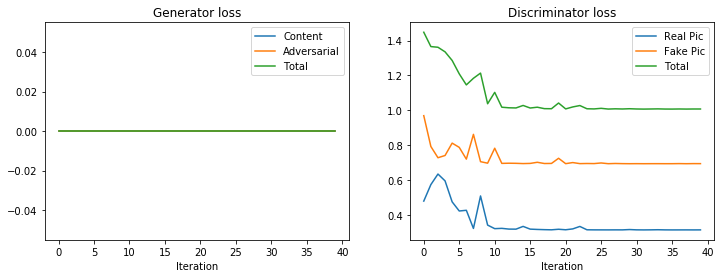


L1 (how bad on real data): 0.313361	 L2 (how bad on fake data): 0.693175
L1 (how bad on real data): 0.313296	 L2 (how bad on fake data): 0.693193
L1 (how bad on real data): 0.314136	 L2 (how bad on fake data): 0.693171
L1 (how bad on real data): 0.313421	 L2 (how bad on fake data): 0.693192
L1 (how bad on real data): 0.313347	 L2 (how bad on fake data): 0.693178
L1 (how bad on real data): 0.313396	 L2 (how bad on fake data): 0.693180
L1 (how bad on real data): 0.313381	 L2 (how bad on fake data): 0.693211
L1 (how bad on real data): 0.314275	 L2 (how bad on fake data): 0.693243
L1 (how bad on real data): 0.313327	 L2 (how bad on fake data): 0.693380
L1 (how bad on real data): 0.313347	 L2 (how bad on fake data): 0.693354
L1 (how bad on real data): 0.313911	 L2 (how bad on fake data): 0.693245
L1 (how bad on real data): 0.313296	 L2 (how bad on fake data): 0.693659
L1 (how bad on real data): 0.313526	 L2 (how bad on fake data): 0.693366
L1 (how bad on real data): 0.313273	 L2 (how bad o

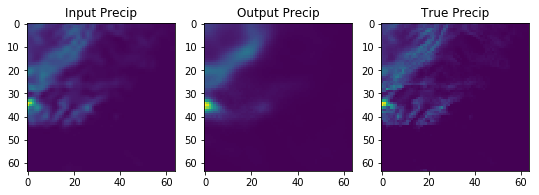

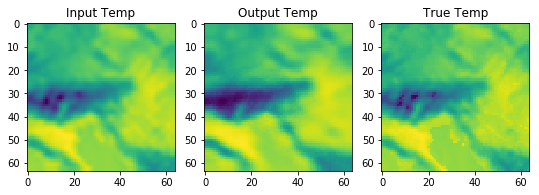

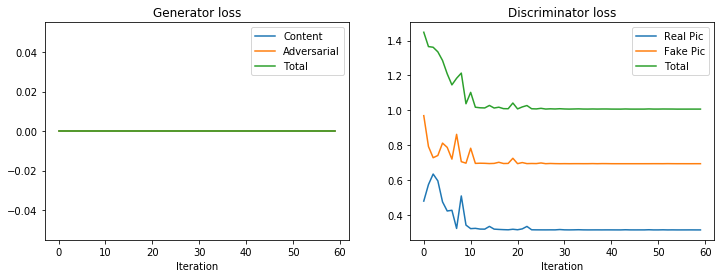


L1 (how bad on real data): 0.313283	 L2 (how bad on fake data): 0.693187
L1 (how bad on real data): 0.313273	 L2 (how bad on fake data): 0.693278
L1 (how bad on real data): 0.313748	 L2 (how bad on fake data): 0.693160
L1 (how bad on real data): 0.313891	 L2 (how bad on fake data): 0.693744
L1 (how bad on real data): 0.313267	 L2 (how bad on fake data): 0.693159
L1 (how bad on real data): 0.313281	 L2 (how bad on fake data): 0.693163
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693175
L1 (how bad on real data): 0.313269	 L2 (how bad on fake data): 0.693160
L1 (how bad on real data): 0.313274	 L2 (how bad on fake data): 0.693918
L1 (how bad on real data): 0.313643	 L2 (how bad on fake data): 0.693207
L1 (how bad on real data): 0.313372	 L2 (how bad on fake data): 0.693167
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693161
L1 (how bad on real data): 0.313276	 L2 (how bad on fake data): 0.693156
L1 (how bad on real data): 0.313276	 L2 (how bad o

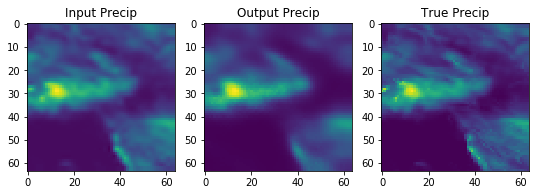

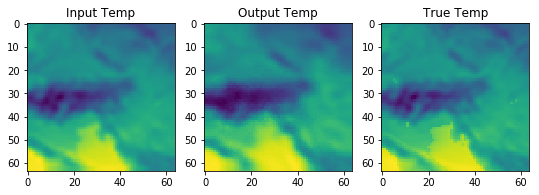

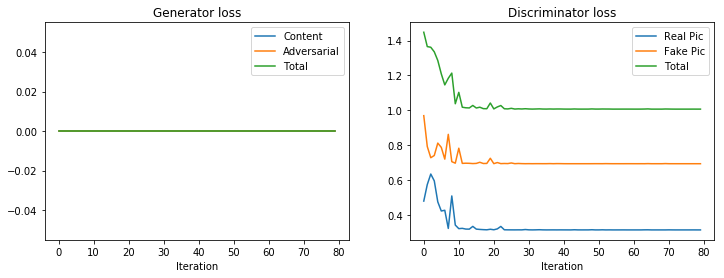


L1 (how bad on real data): 0.313264	 L2 (how bad on fake data): 0.693182
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693152
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693153
L1 (how bad on real data): 0.313334	 L2 (how bad on fake data): 0.693149
L1 (how bad on real data): 0.313392	 L2 (how bad on fake data): 0.693155
L1 (how bad on real data): 0.313264	 L2 (how bad on fake data): 0.693151
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693156
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693162
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693168
L1 (how bad on real data): 0.313266	 L2 (how bad on fake data): 0.693174
L1 (how bad on real data): 0.313264	 L2 (how bad on fake data): 0.693156
L1 (how bad on real data): 0.313267	 L2 (how bad on fake data): 0.693158
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693153
L1 (how bad on real data): 0.313263	 L2 (how bad o

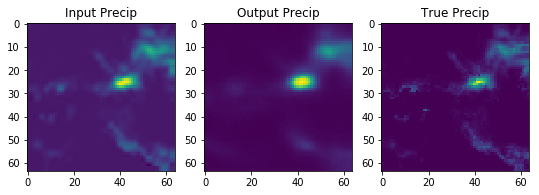

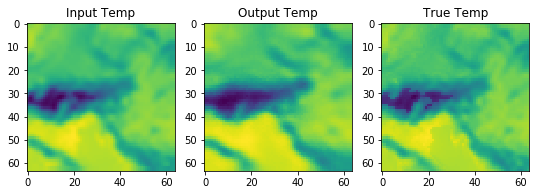

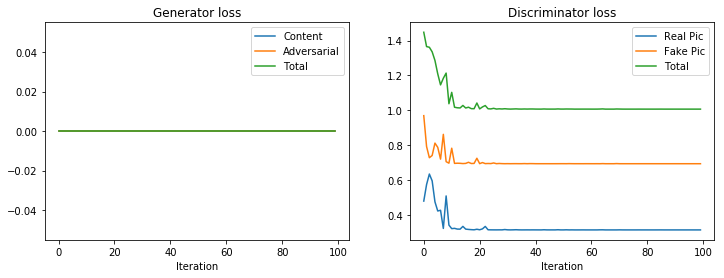


L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693150
L1 (how bad on real data): 0.313268	 L2 (how bad on fake data): 0.693151
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693150
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693156
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693150
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313268	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313264	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313264	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313300	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693149
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693152
L1 (how bad on real data): 0.313262	 L2 (how bad o

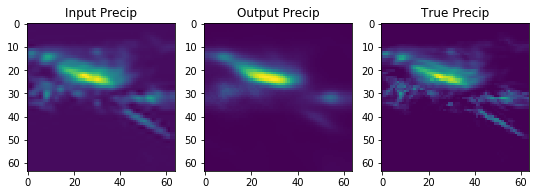

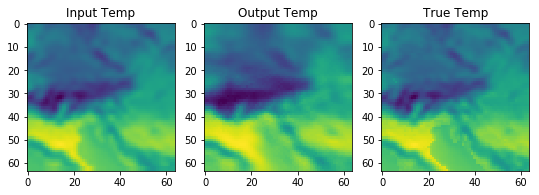

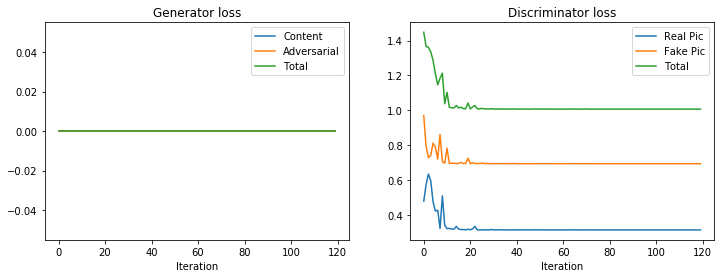


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313267	 L2 (how bad on fake data): 0.693149
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693163
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313270	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693149
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313264	 L2 (how bad o

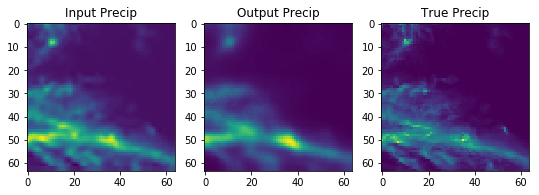

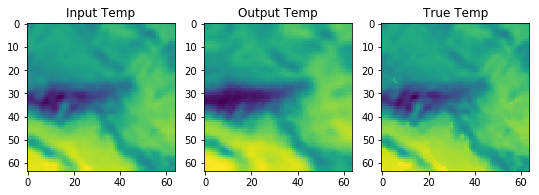

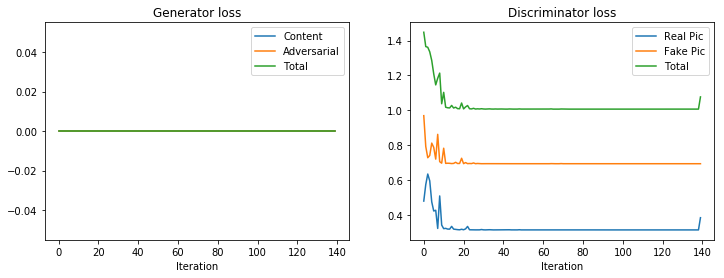


L1 (how bad on real data): 0.313264	 L2 (how bad on fake data): 0.693149
L1 (how bad on real data): 0.313271	 L2 (how bad on fake data): 0.693154
L1 (how bad on real data): 0.313348	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.340049	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693149
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693166
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693184
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.767104
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313266	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313293	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313840	 L2 (how bad o

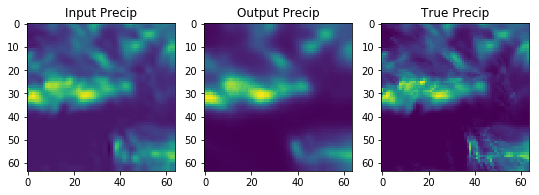

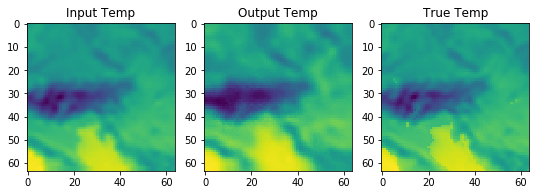

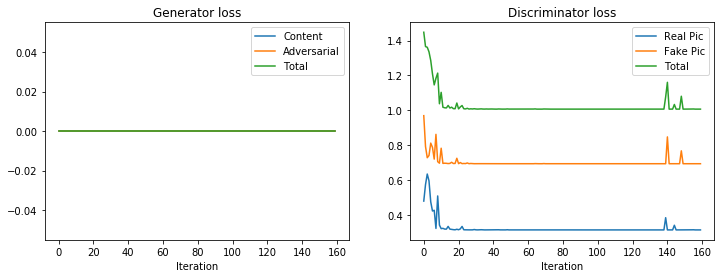


L1 (how bad on real data): 0.314450	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313264	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313278	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313267	 L2 (how bad o

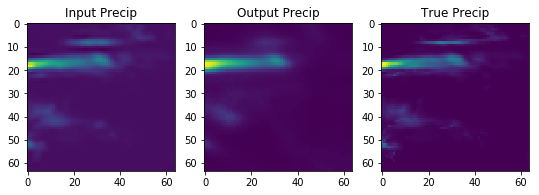

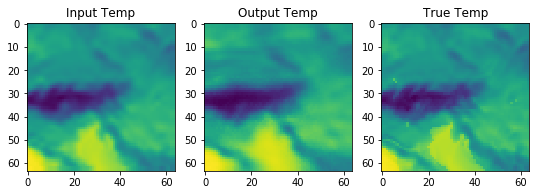

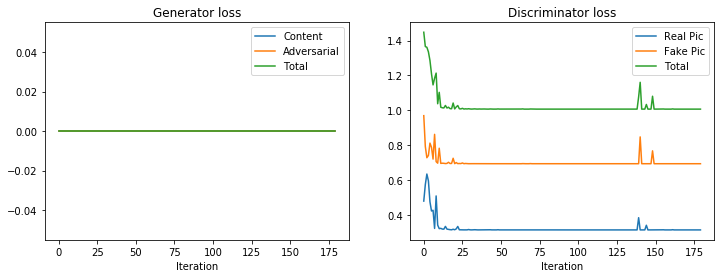


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313327	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313266	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313278	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693150
L1 (how bad on real data): 0.313262	 L2 (how bad o

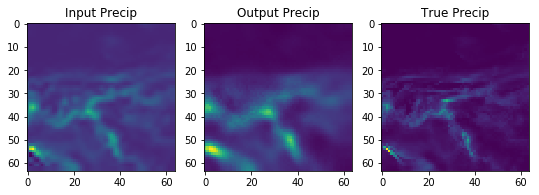

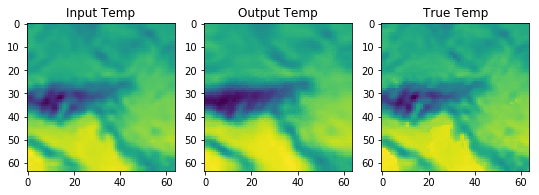

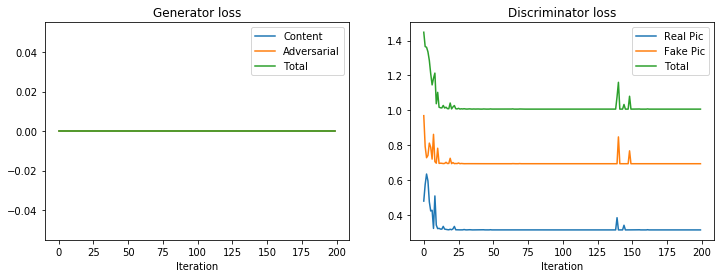


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693149
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad o

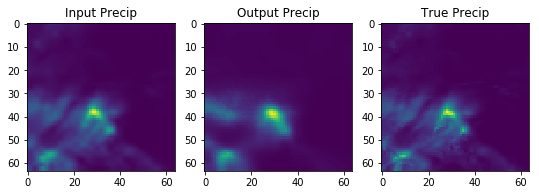

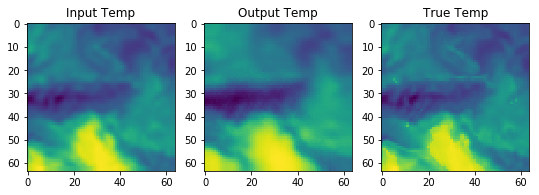

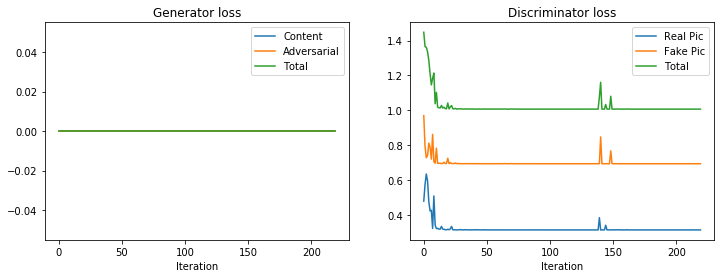


L1 (how bad on real data): 0.313264	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693214
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313267	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313264	 L2 (how bad o

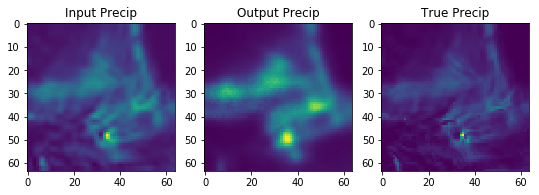

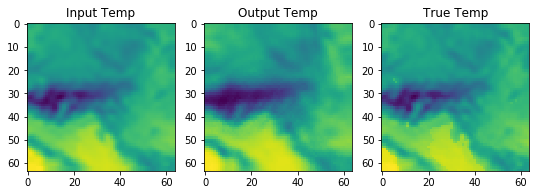

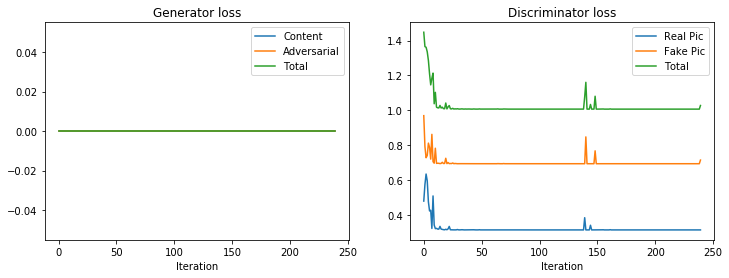


L1 (how bad on real data): 0.313267	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313285	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.314121	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313312	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313270	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

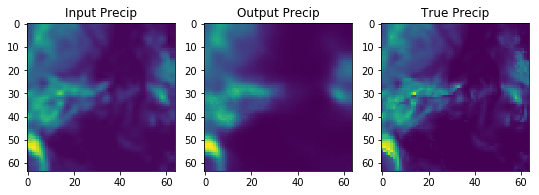

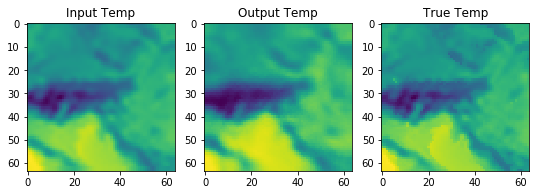

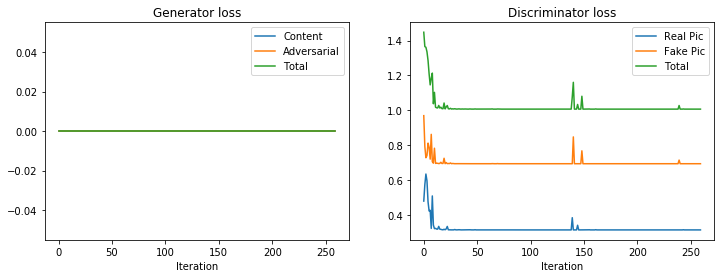


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313268	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313346	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

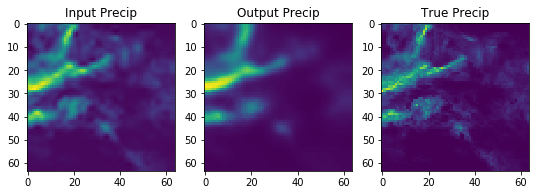

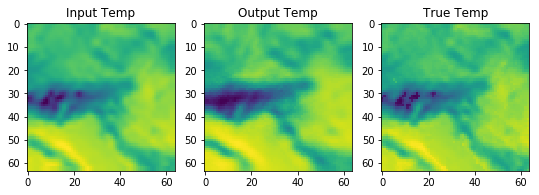

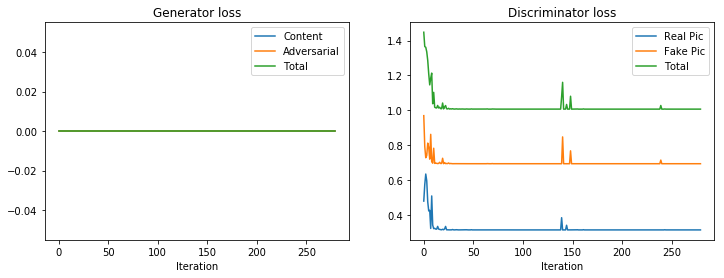


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

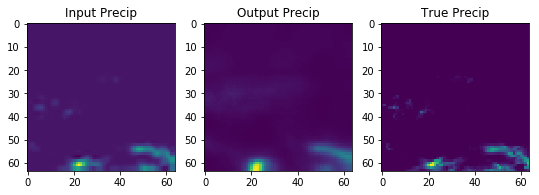

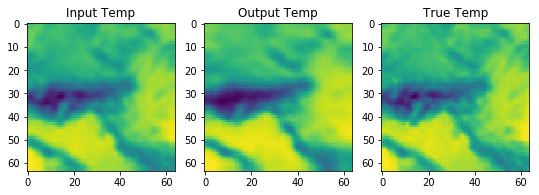

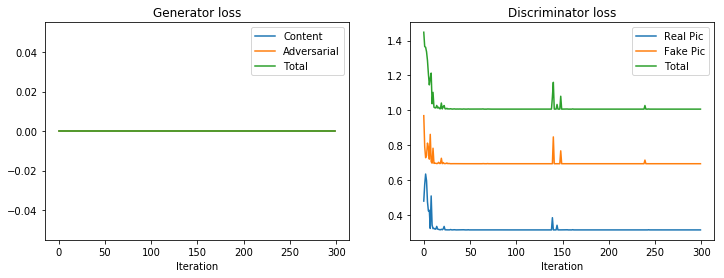


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

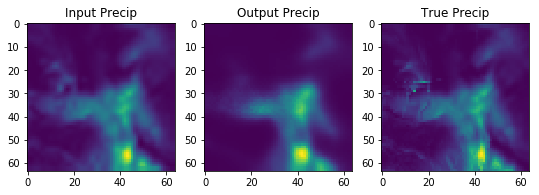

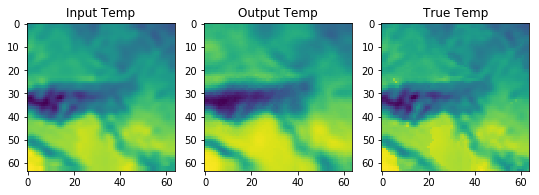

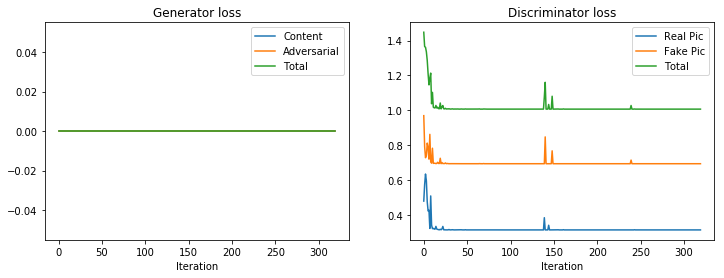


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693149
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

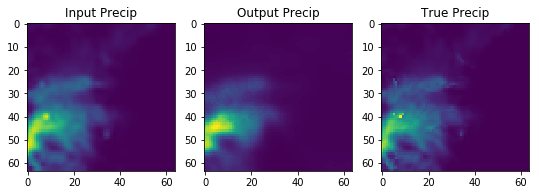

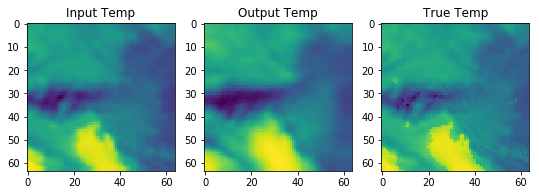

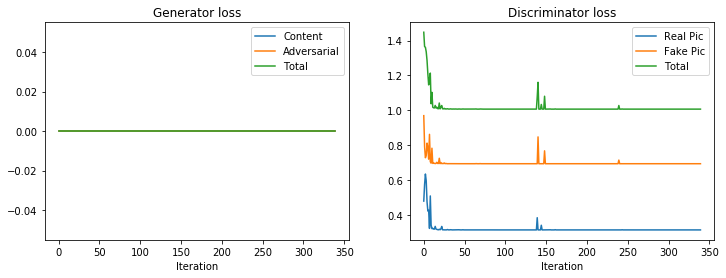


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

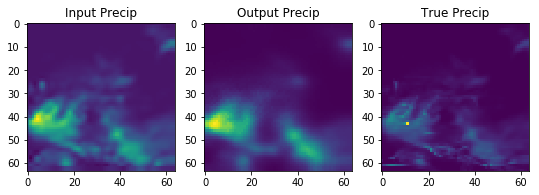

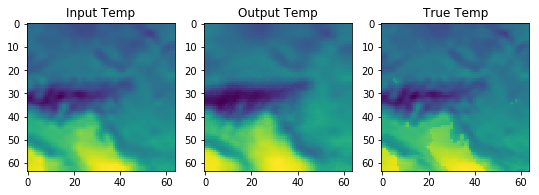

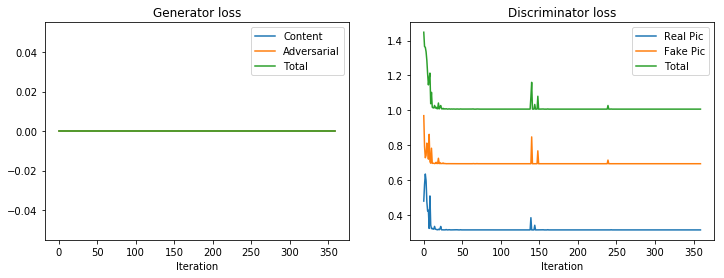


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

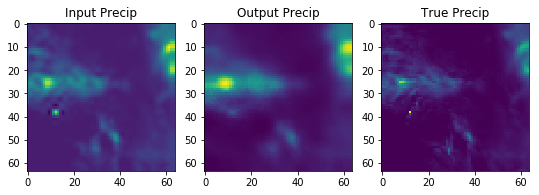

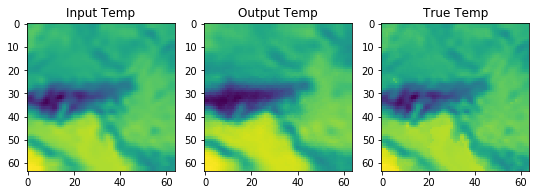

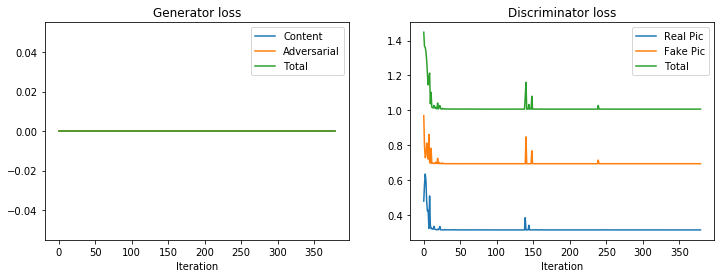


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

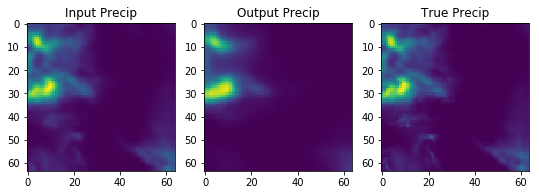

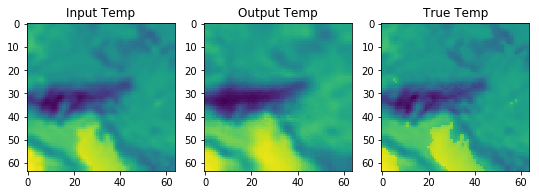

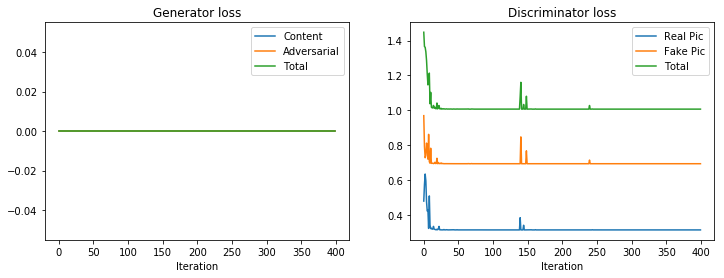


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313280	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693162
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693165
L1 (how bad on real data): 0.313346	 L2 (how bad o

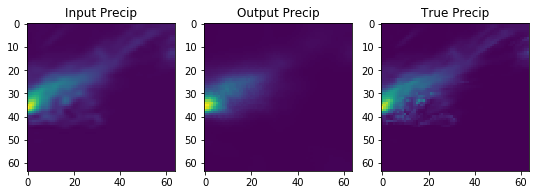

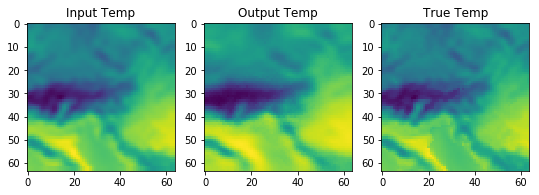

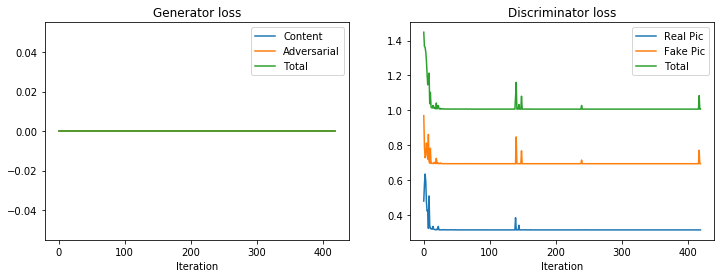


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

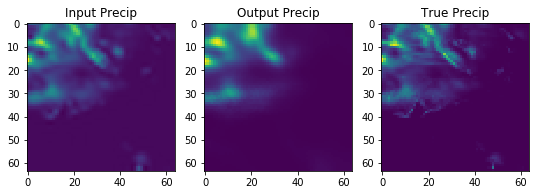

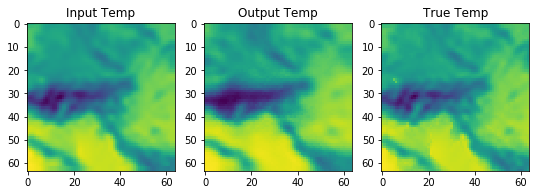

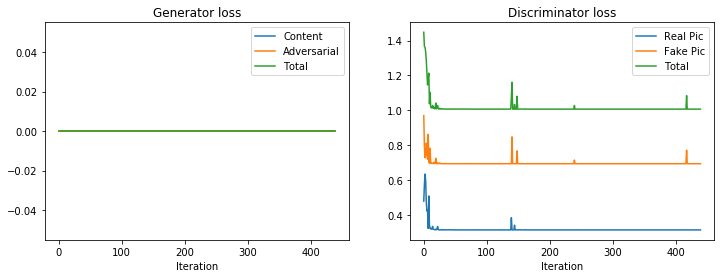


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

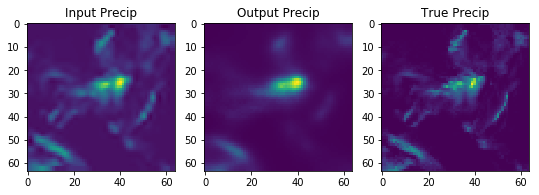

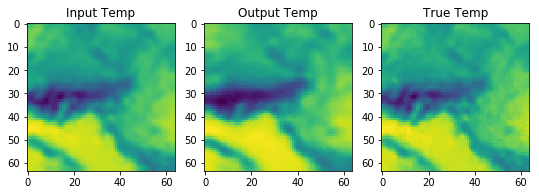

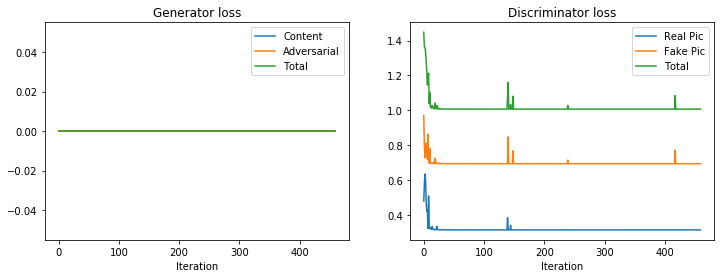


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

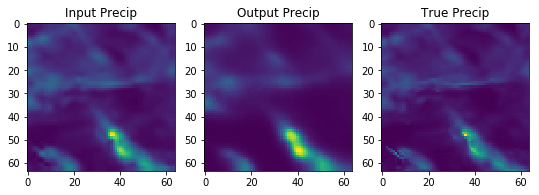

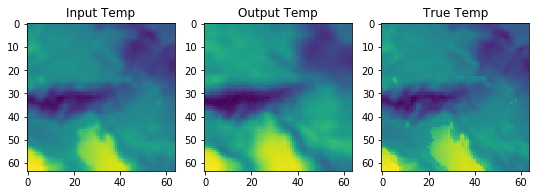

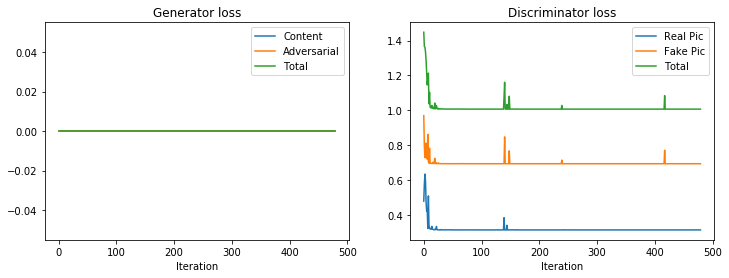


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313265	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693148
L1 (how bad on real data): 0.313262	 L2 (how bad o

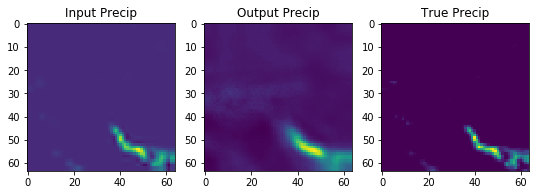

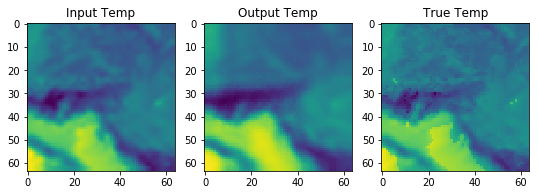

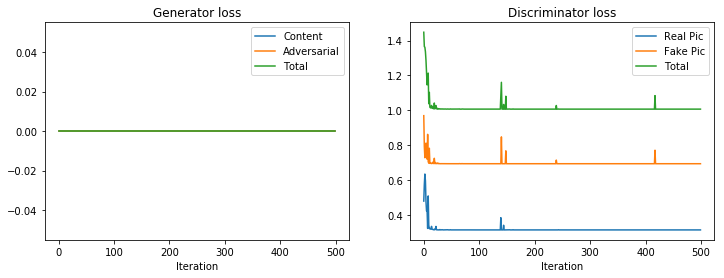


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

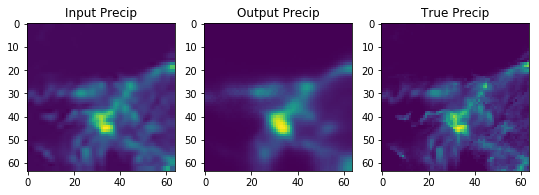

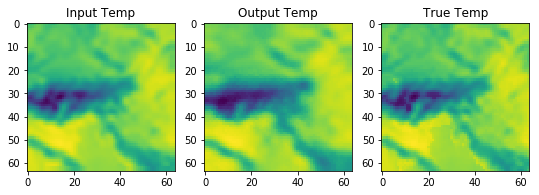

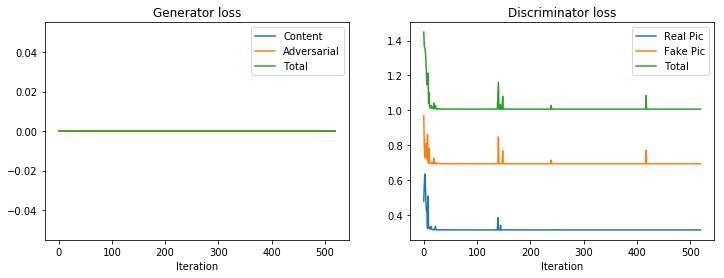


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

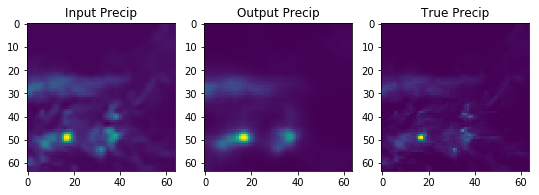

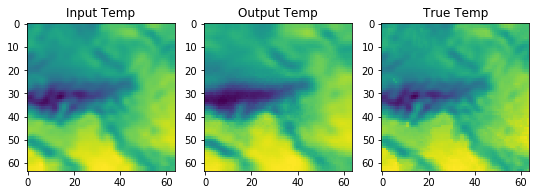

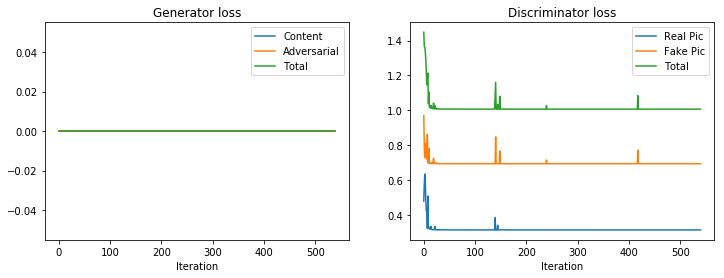


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

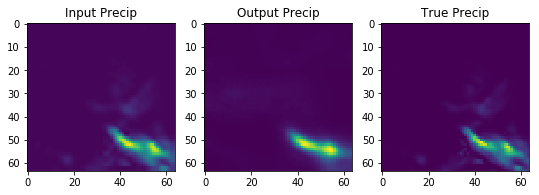

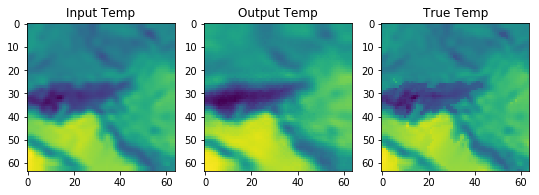

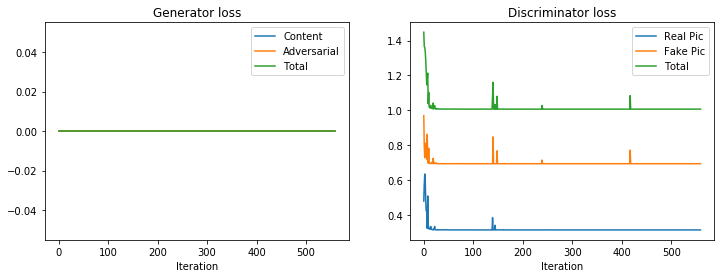


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

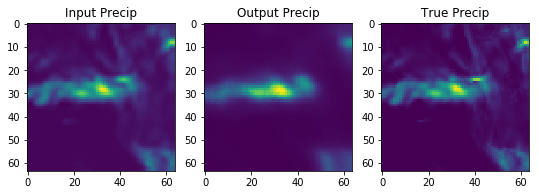

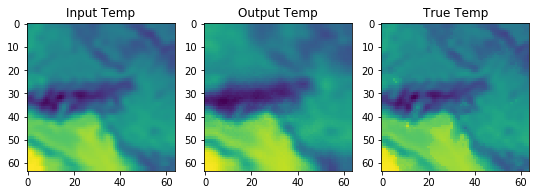

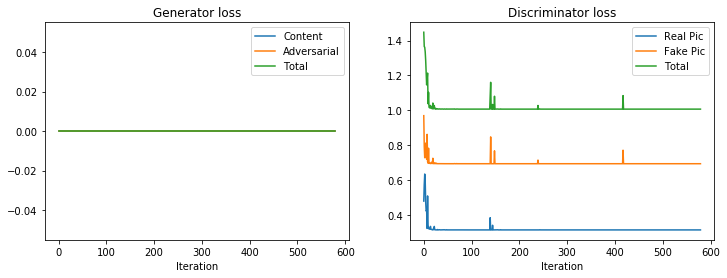


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

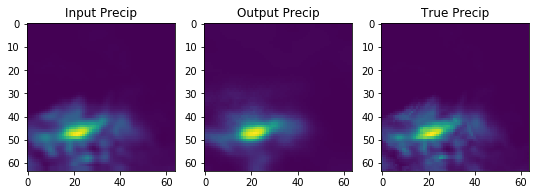

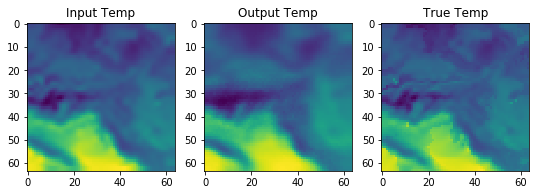

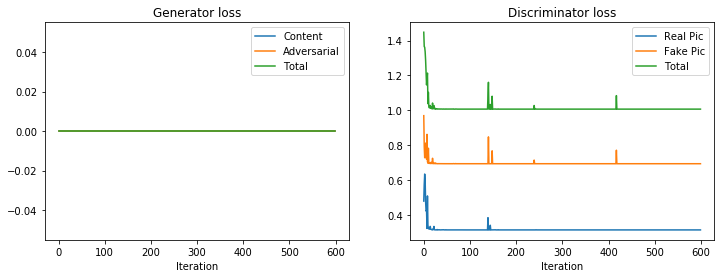


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

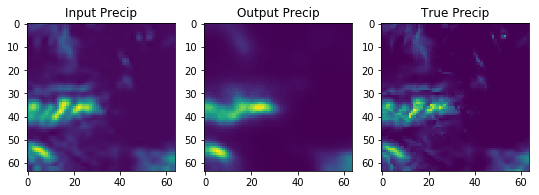

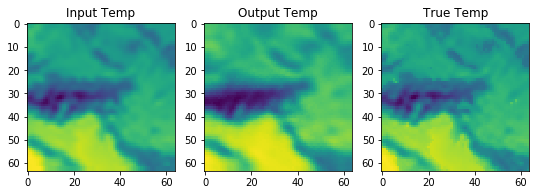

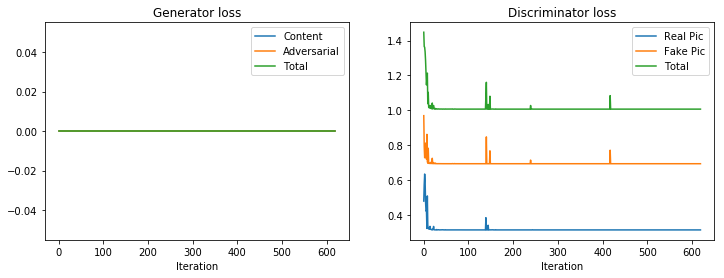


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

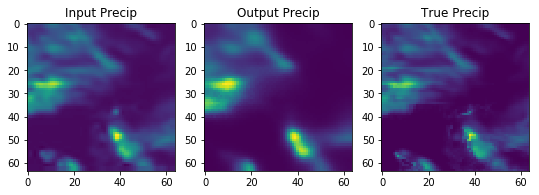

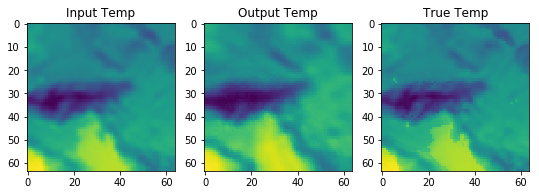

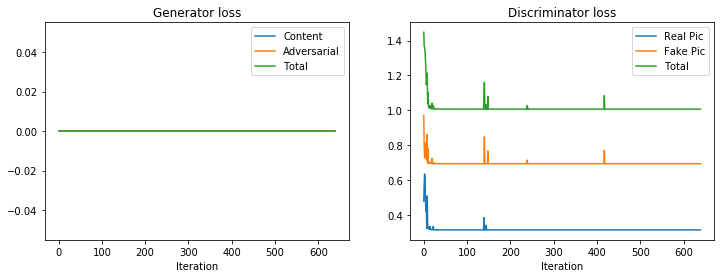


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

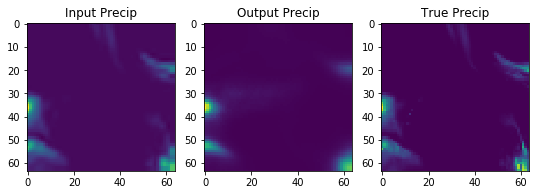

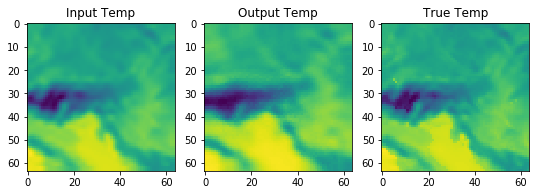

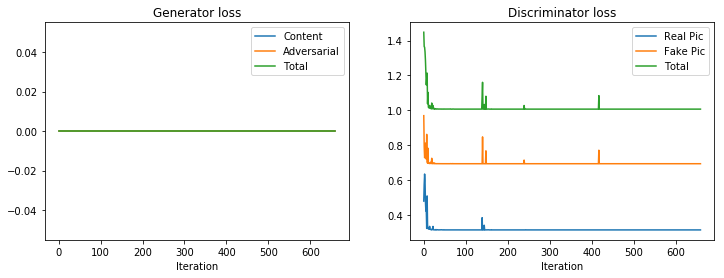


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

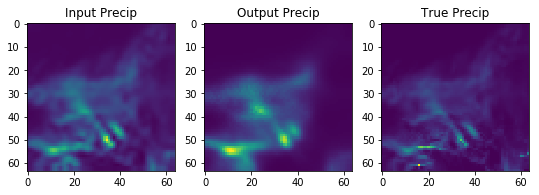

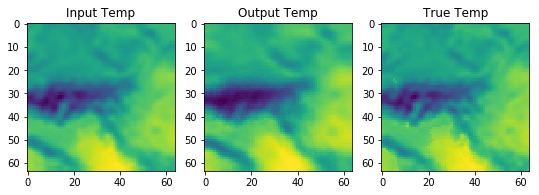

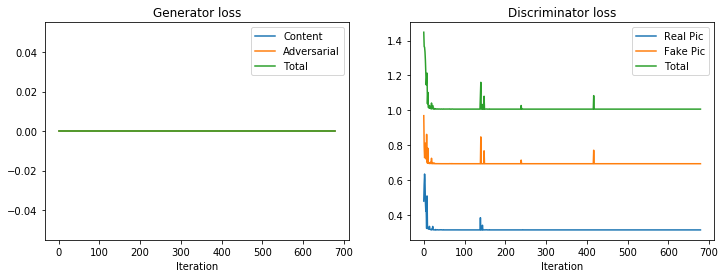


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

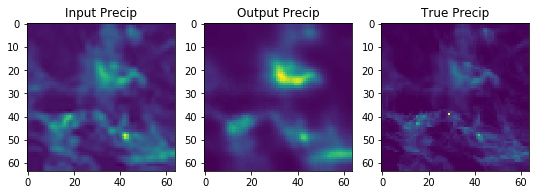

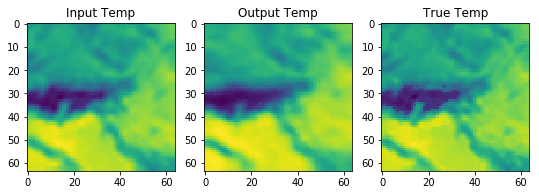

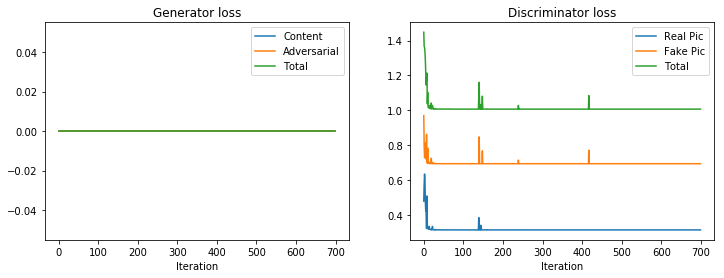


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

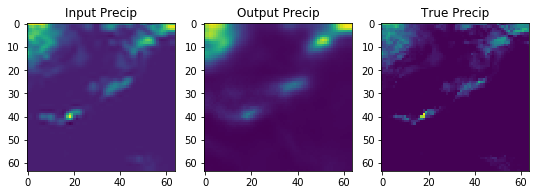

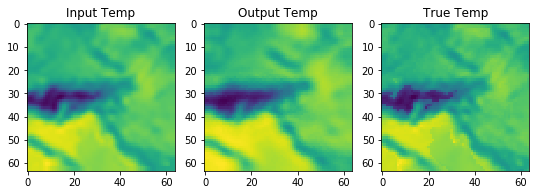

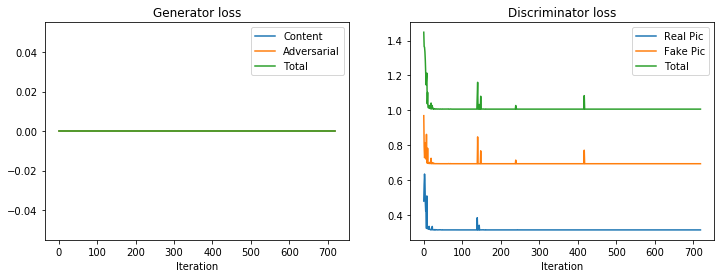


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

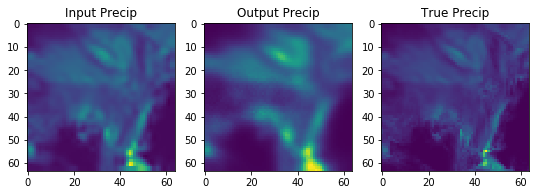

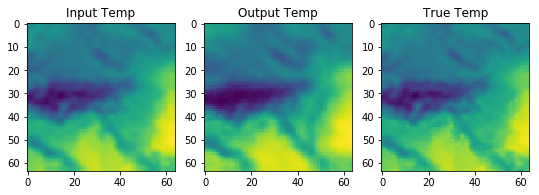

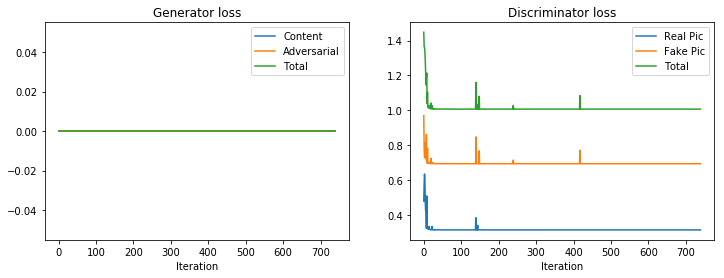


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

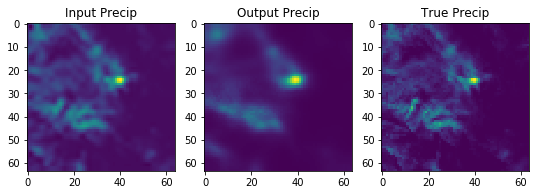

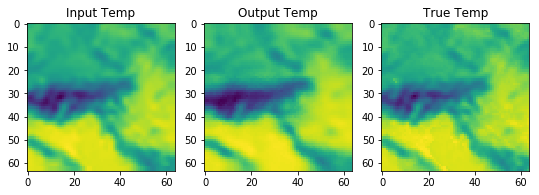

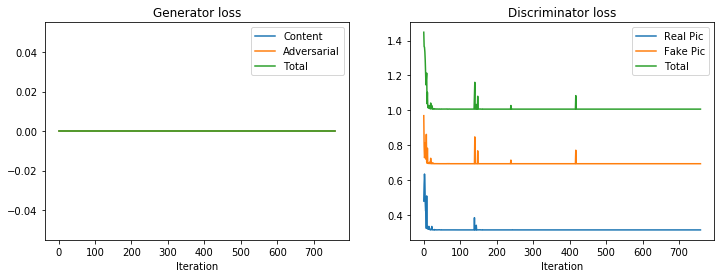


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

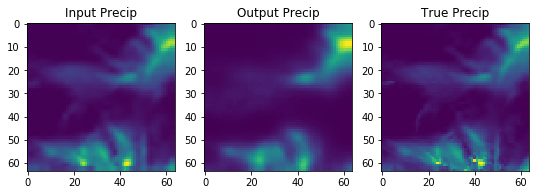

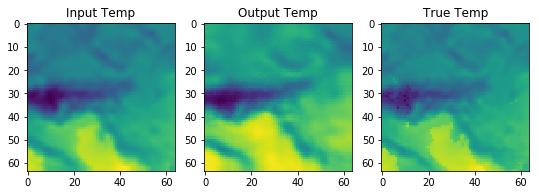

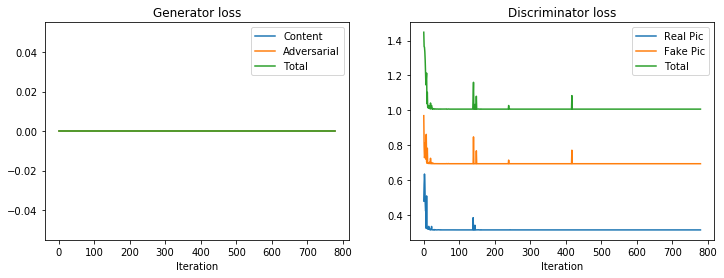


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

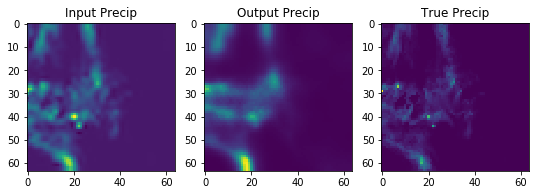

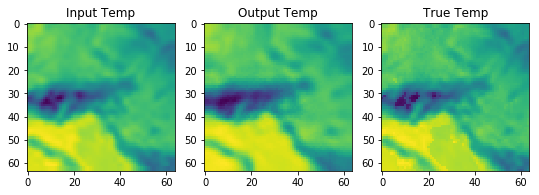

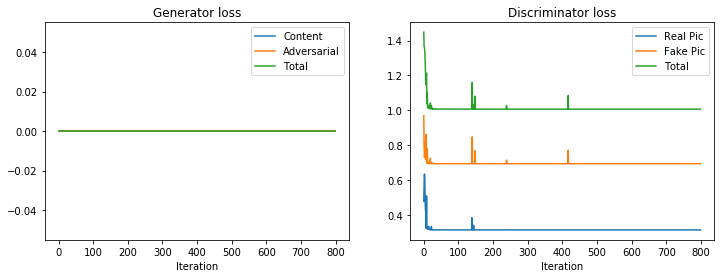


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

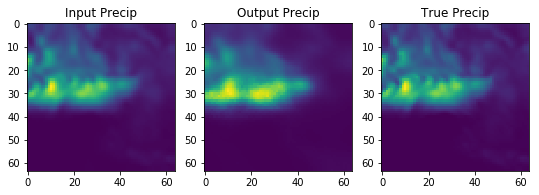

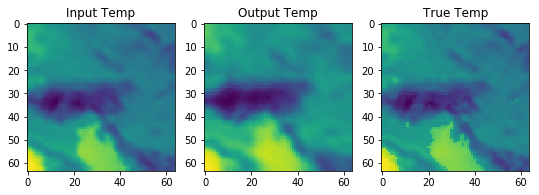

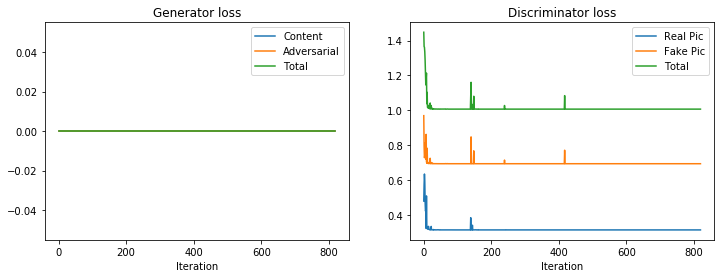


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

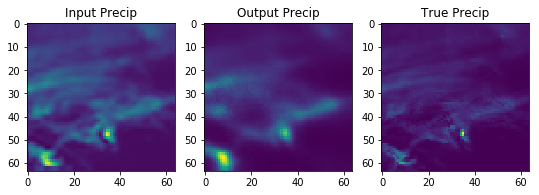

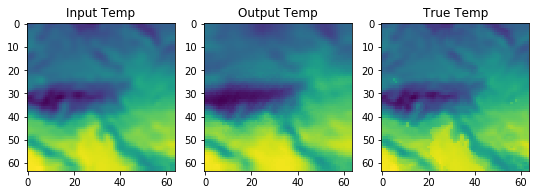

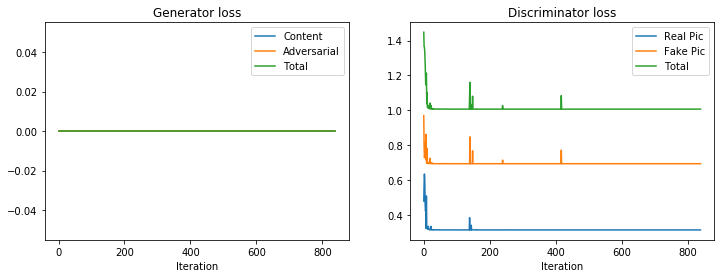


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

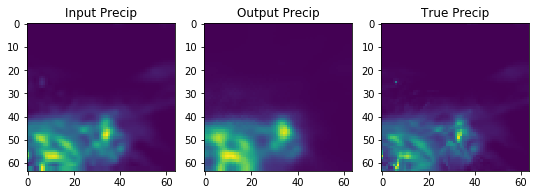

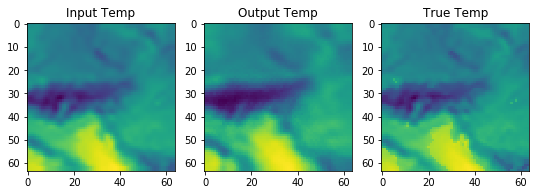

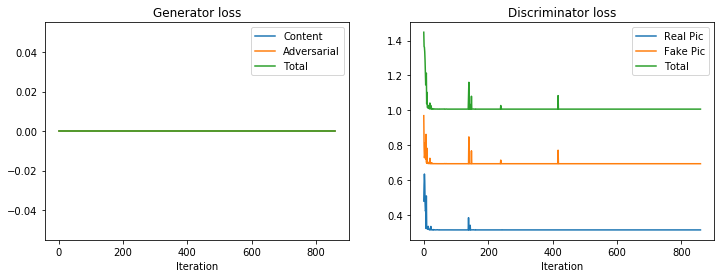


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

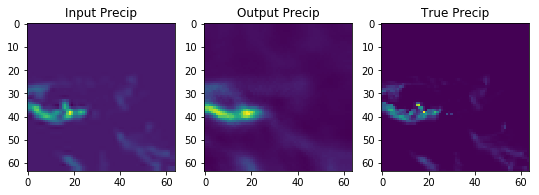

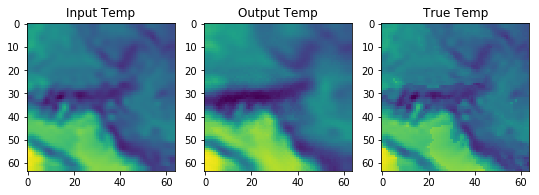

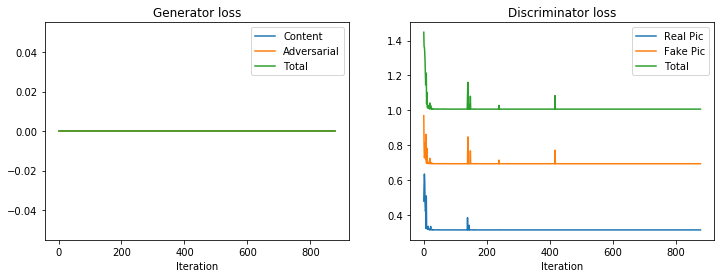


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.314982	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

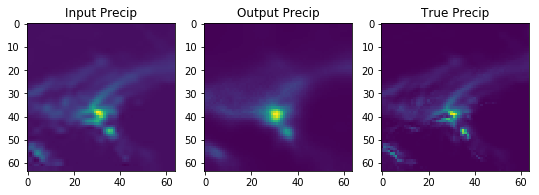

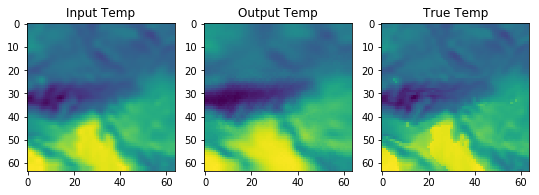

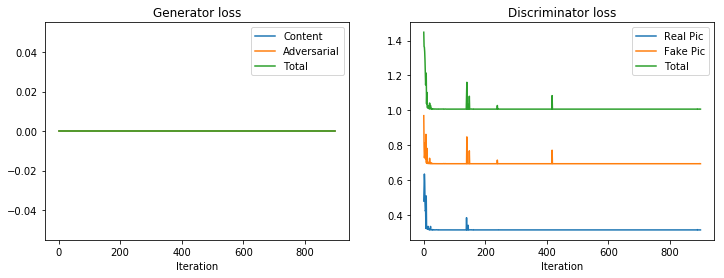


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313263	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313292	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

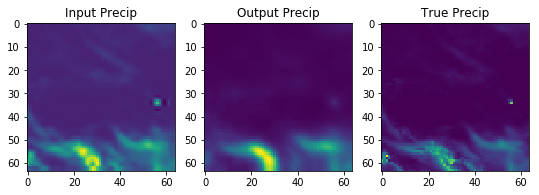

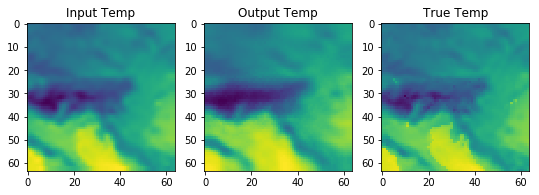

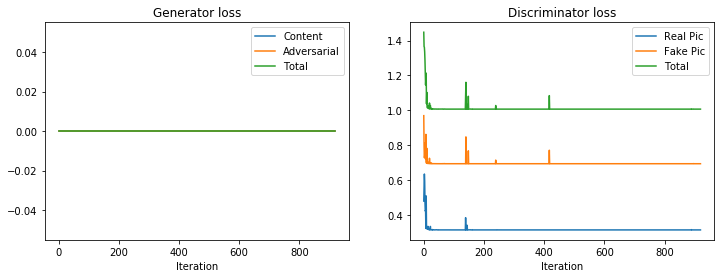


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

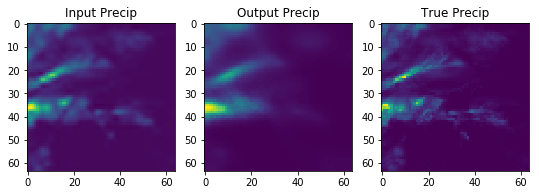

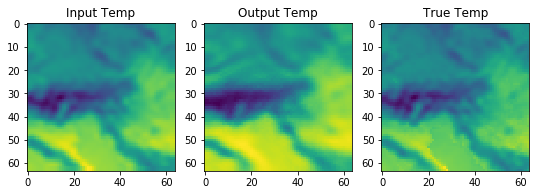

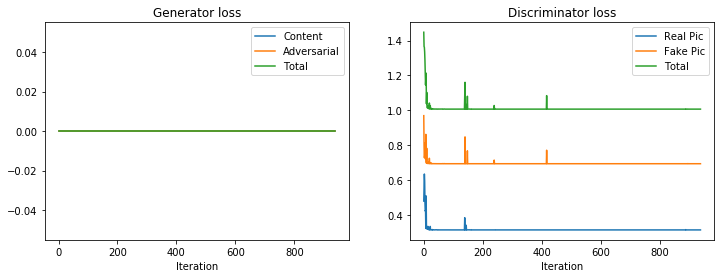


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

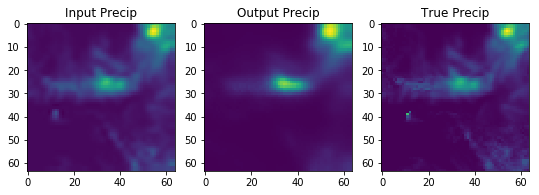

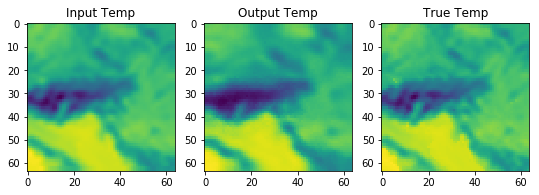

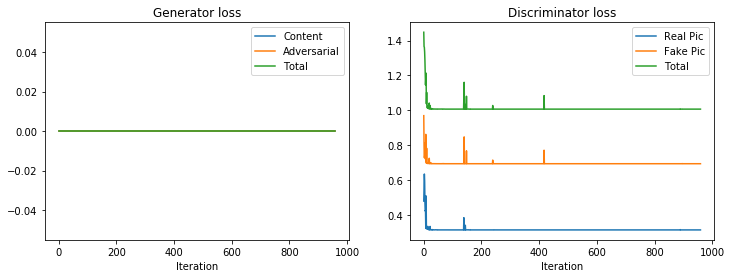


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

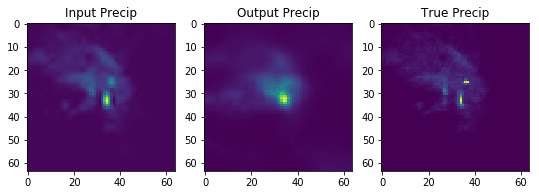

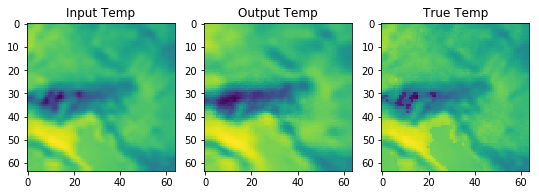

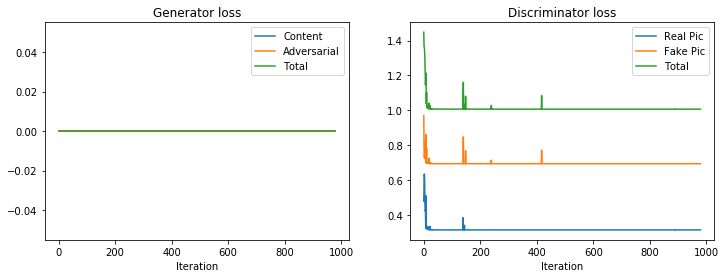


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

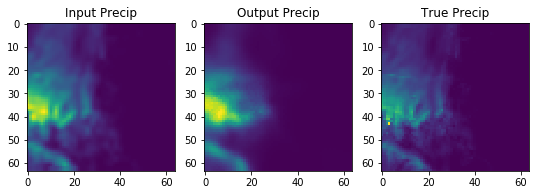

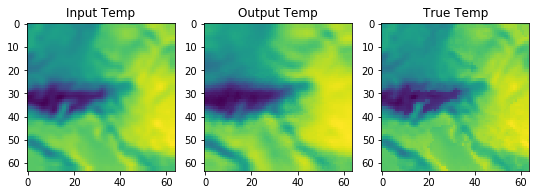

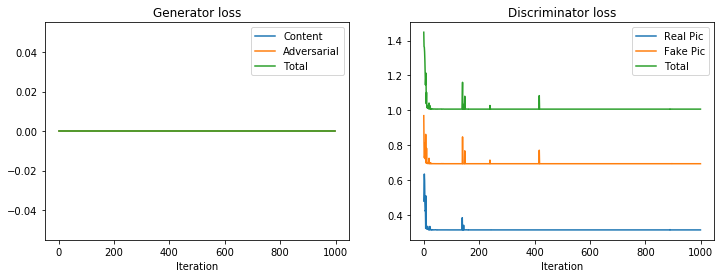


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

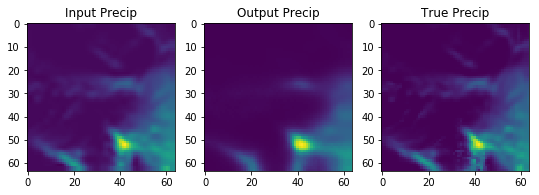

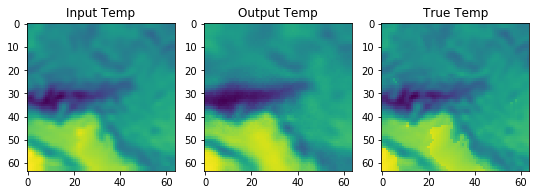

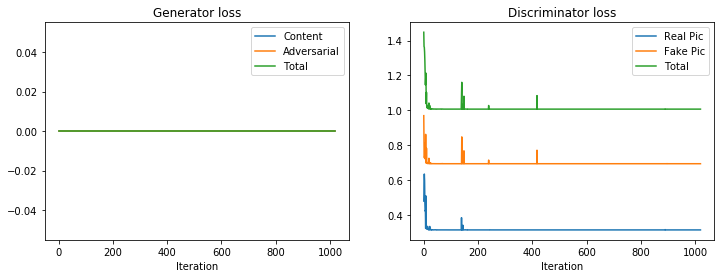


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313527	 L2 (how bad o

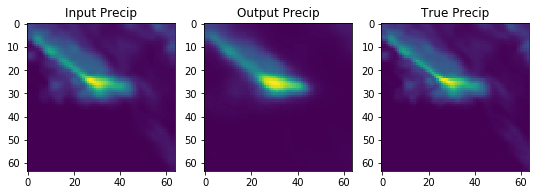

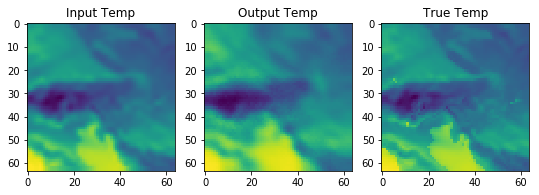

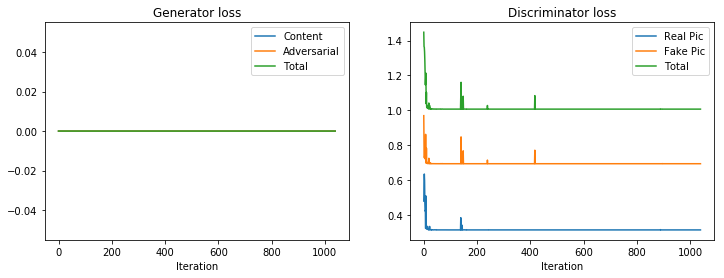


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

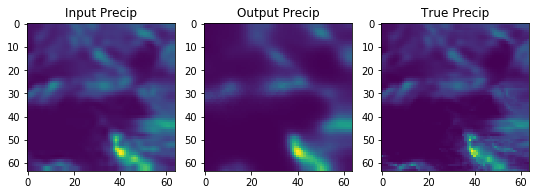

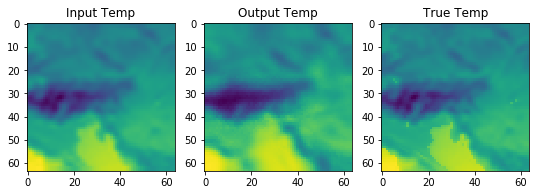

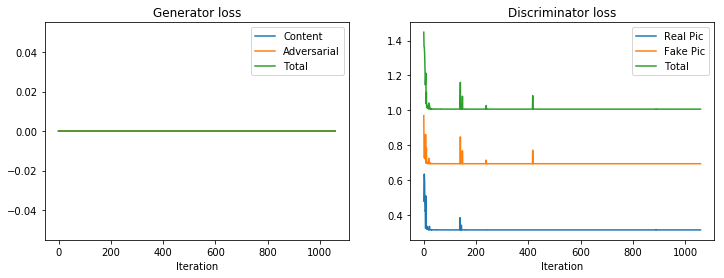


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693204
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

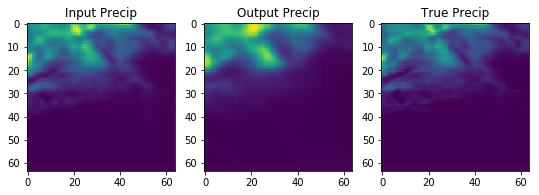

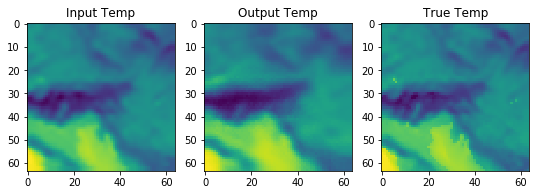

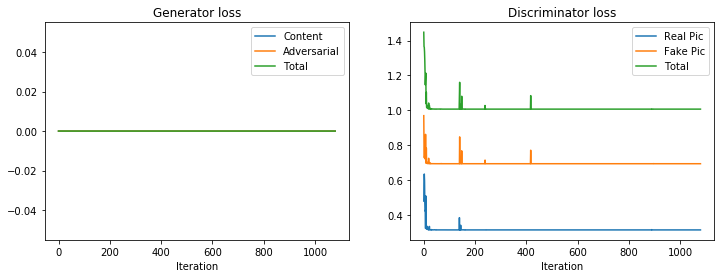


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

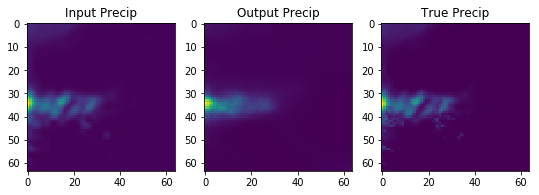

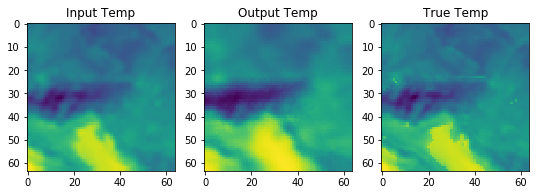

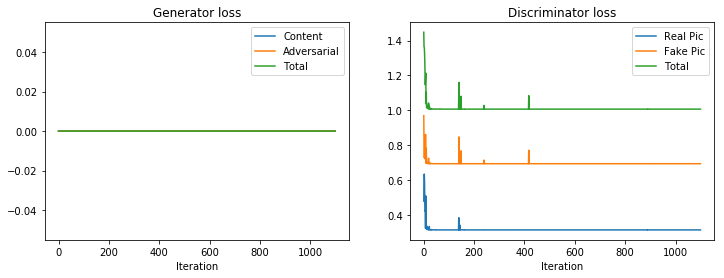


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

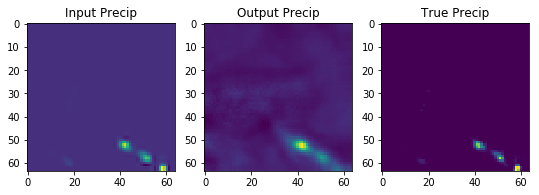

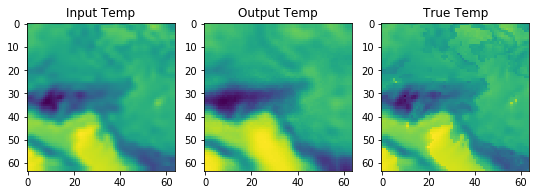

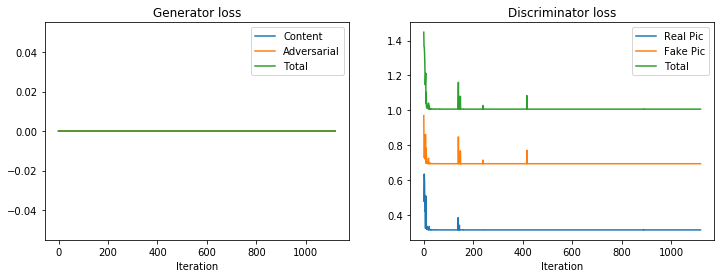


L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad on fake data): 0.693147
L1 (how bad on real data): 0.313262	 L2 (how bad o

Process Process-97:
Process Process-100:
Process Process-98:
Process Process-99:
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/proc

KeyboardInterrupt: 

In [57]:
D = Discriminator(num_channels=2, H=IMG_HEIGHT, W=IMG_WIDTH)
G = Generator(num_channels=3)

# Initialize the Generator to the checkpoint created when training it alone
G.load_state_dict(torch.load('training_Generator_checkpoint.pt'))

D_solver = get_optimizer(D, lr=1e-4)
G_solver = get_optimizer(G)

run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=20)